Saved: /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap.pdf and /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap.jpg


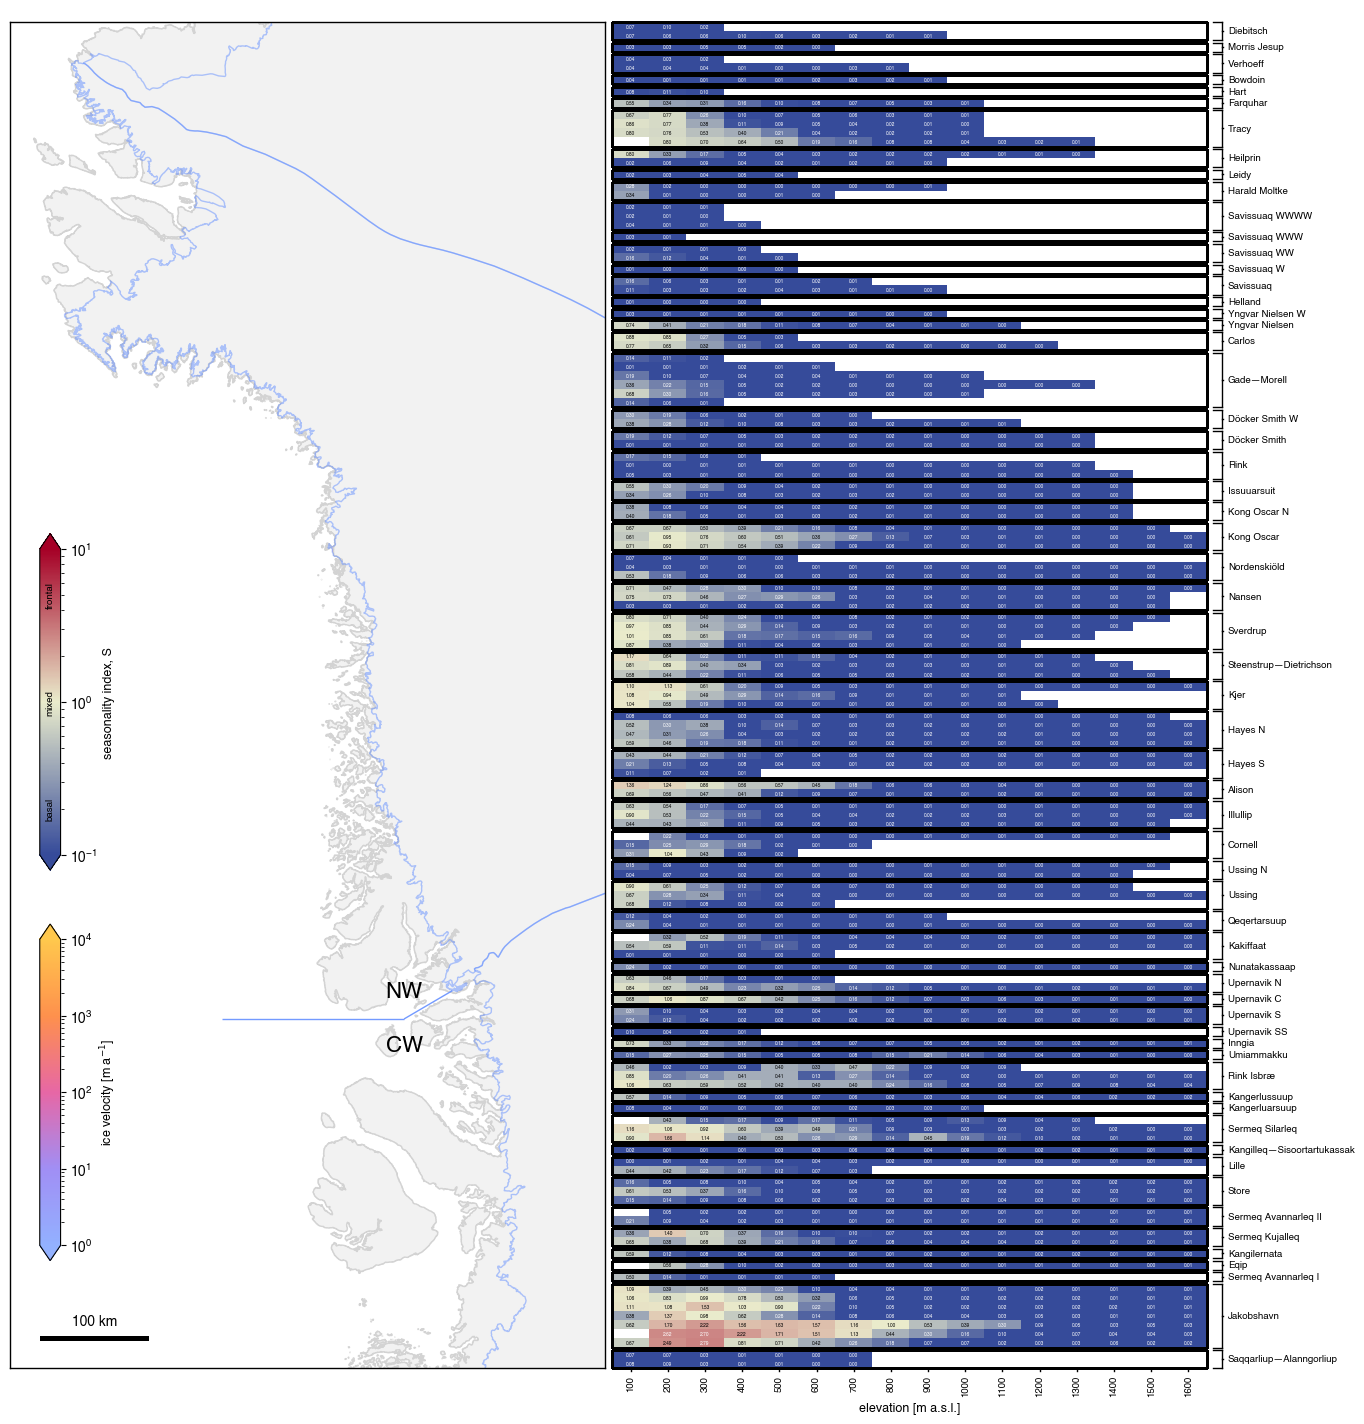

In [3]:
#test map without connectors

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from shapely.geometry import Point

# === Global font: Helvetica ===
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['mathtext.fontset'] = 'dejavusans'

# --- Paths ---
os.chdir("/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Jess ITS_LIVE v2/Map")
out_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap"
os.makedirs(out_dir, exist_ok=True)

heat_csv = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric1.csv"

# --- Map data ---
_ = pd.read_csv("2016_20_hmm.csv")  # legacy
outline_gdf     = gpd.read_file("NW_CW_outline.shp").to_crs("EPSG:3413")
outline_big_gdf = gpd.read_file("NW_CW_SW_NO_outline.shp").to_crs("EPSG:3413")
greenland_gdf   = gpd.read_file("greenland_outlines.shp").to_crs("EPSG:3413")

minx, miny, maxx, maxy = outline_gdf.total_bounds
buffer = 50000
xmin = minx - (buffer*1)
xmax = maxx - (buffer*8)
ymin = miny + buffer
ymax = maxy + buffer
greenland_clipped = greenland_gdf.cx[xmin:xmax, ymin:ymax]

# --- Colour maps & norms ---
heat_cmap = mcolors.LinearSegmentedColormap.from_list("heat_cmap", ["#364B9A", "#EAECCC", "#A50026"])
driver_norm = LogNorm(vmin=0.1, vmax=10)

custom_cmap = LinearSegmentedColormap.from_list("custom_log_cmap",
                                                ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"])
def lighten_color(c, amount=0.3):
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(c)
    return (1 - (1-r)*(1-amount), 1 - (1-g)*(1-amount), 1 - (1-b)*(1-amount))
light_cmap   = LinearSegmentedColormap.from_list(
    "light_log_cmap",
    [lighten_color(c) for c in ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]]
)
velocity_norm = LogNorm(vmin=1, vmax=10000)

# --- Heatmap data ---
hm_df = pd.read_csv(heat_csv)
for col in ["glacier_ID", "flowline_ID"]:
    hm_df[col] = pd.to_numeric(hm_df[col], errors='coerce')

elev_cols = [c for c in hm_df.columns if re.fullmatch(r"\d+", str(c))]
elev_cols = sorted(elev_cols, key=lambda x: int(x))
hm_df[elev_cols] = hm_df[elev_cols].apply(pd.to_numeric, errors='coerce')

# order: glacier_ID ↑, flowline_ID ↑; top row = lowest glacier_ID
hm_df_sorted = hm_df.sort_values(["glacier_ID", "flowline_ID"],
                                 ascending=[True, True]).reset_index(drop=True)

# --- Match heatmap box to map box ---
map_width  = xmax - xmin
map_height = ymax - ymin

num_cells = 16
cell_size = map_width / num_cells
n_rows    = len(hm_df_sorted)

groups      = hm_df_sorted["glacier_ID"].to_numpy()
unique_gids = pd.unique(groups)
ngaps       = max(0, len(unique_gids) - 1)

# subgroup gaps
nominal_row_h  = map_height / max(1, n_rows)
gap_thin       = 0.25 * nominal_row_h
total_gap_h    = gap_thin * ngaps
if total_gap_h > 0.15 * map_height:
    gap_thin = (0.15 * map_height) / max(1, ngaps)
    total_gap_h = gap_thin * ngaps

bar_height = (map_height - total_gap_h) / max(1, n_rows)

# y0 for each row including group gaps
y0_list = []
acc_gap = 0.0
prev_gid = None
for idx, gid in enumerate(groups):
    if idx > 0 and gid != prev_gid:
        acc_gap += gap_thin
    y0_list.append(idx * bar_height + acc_gap)
    prev_gid = gid
y0_list = np.array(y0_list)

hm_x0, hm_y0 = 0.0, 0.0
hm_x1, hm_y1 = map_width, map_height

# --- Line widths (consistency) ---
MAP_LINE_W       = 1.0
GROUP_LINE_W     = MAP_LINE_W
BRACKET_LINE_W   = GROUP_LINE_W

# --- Figure / layout (equal panel widths) ---
fig_w = 14.0
width_ratios = [1.0, 1.0]
map_frac = width_ratios[0] / sum(width_ratios)
fig_h = max(8.0, fig_w * map_frac * (map_height / map_width))

fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=width_ratios, wspace=0.0)
fig.subplots_adjust(left=0.06, right=0.94, top=0.98, bottom=0.13, wspace=0.0)

ax_map  = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])

# =========================
# MAP (left) — raster clipped to outline_big_gdf
# =========================
greenland_clipped.plot(ax=ax_map, facecolor='#F2F2F2', edgecolor='none', linewidth=0)

greenland_clipped.plot(ax=ax_map, edgecolor='lightgrey', facecolor='none', linewidth=MAP_LINE_W)

with rasterio.open("v_2022.tif") as src:
    # Reproject outline to raster CRS if needed
    clip_gdf = outline_big_gdf
    if clip_gdf.crs is not None and src.crs is not None:
        if clip_gdf.crs.to_string().upper() != src.crs.to_string().upper():
            clip_gdf = clip_gdf.to_crs(src.crs)

    # Mask the raster to the polygon(s); keep full extent (crop=False) so extents stay consistent
    geoms = [mapping(geom) for geom in clip_gdf.geometry if not geom.is_empty]
    masked, _ = rmask.mask(src, geoms, crop=False, filled=True)
    data = masked[0].astype(float)

    # Log-safe & hide masked/outside areas
    data[data <= 0] = np.nan

    ax_map.imshow(
        data,
        cmap=custom_cmap,
        norm=velocity_norm,
        extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
        origin='upper',
        interpolation='none',
        alpha=0.3
    )

# Outlines over the clipped raster
outline_big_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.5, facecolor='none', linewidth=MAP_LINE_W)

# Map bounds, style, spines
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_aspect('equal')
ax_map.set_title("")
ax_map.set_xticks([]); ax_map.set_yticks([])
ax_map.set_xlabel(""); ax_map.set_ylabel("")
for side in ax_map.spines:
    ax_map.spines[side].set_visible(True)
    ax_map.spines[side].set_linewidth(MAP_LINE_W)
    ax_map.spines[side].set_edgecolor('black')
    ax_map.spines[side].set_zorder(10)

# --- Scale bar (lower-left, just below the legends) + "NO" label at old spot ---

scalebar_length = 100_000   # 100 km
scalebar_height = 5000

# Place relative to the map extent: align x with legend left (≈0.05), y just below velocity legend (below 0.08)
x_bar = xmin + 0.05 * (xmax - xmin)
y_bar = ymin + 0.02 * (ymax - ymin)

# Draw the bar
ax_map.add_patch(plt.Rectangle((x_bar, y_bar),
                               scalebar_length, scalebar_height,
                               facecolor='black', zorder=12))
# Label it (above the bar to avoid bottom clipping)
ax_map.text(x_bar + scalebar_length / 2,
            y_bar + scalebar_height + 7000,
            "100 km", ha='center', va='bottom', fontsize=10, zorder=12)

# --- Map legends (inside map, lower-left) ---
def _add_inmap_axes(ax, rel_left, rel_bottom, rel_width, rel_height):
    bb = ax.get_position()
    return fig.add_axes([bb.x0 + rel_left * bb.width,
                         bb.y0 + rel_bottom * bb.height,
                         rel_width * bb.width,
                         rel_height * bb.height])

cax_vel = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.08, rel_width=0.035, rel_height=0.25)
cax_drv = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.37, rel_width=0.035, rel_height=0.25)

sm_driver = plt.cm.ScalarMappable(norm=driver_norm, cmap=heat_cmap); sm_driver.set_array([])
cbar_drv = plt.colorbar(sm_driver, cax=cax_drv, orientation='vertical', extend='both')
cbar_drv.set_label("seasonality index, S", fontsize=9)
cbar_drv.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_drv.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_drv.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_drv.ax.yaxis.set_minor_formatter(NullFormatter())
cax_drv.text(0.5, 0.85, "frontal",    ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.50, "mixed",      ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.15, "basal", ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)

sm_raster = plt.cm.ScalarMappable(norm=velocity_norm, cmap=light_cmap); sm_raster.set_array([])
cbar_vel = plt.colorbar(sm_raster, cax=cax_vel, orientation='vertical', extend='both')
cbar_vel.set_label("ice velocity [m a$^{-1}$]", fontsize=9)
cbar_vel.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_vel.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_vel.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_vel.ax.yaxis.set_minor_formatter(NullFormatter())

# --- Custom 3413 line segments + 'NW'/'CW' labels (match outline_big_gdf style) ---
OL_COLOR = "#648FFF"    # same as outline_big_gdf edgecolor
OL_LW    = MAP_LINE_W   # same width as map outline


ALPHA = 0.5          # same alpha used for outline_big_gdf

# Segment endpoints (in EPSG:3413)
xA, yA = -252750.652, -1989477.458
xB, yB = -296916.769, -2015351.266   # bend point
xC, yC = -463553.783, -2015351.266   # end of horizontal

# Segment 1: A -> B (diagonal)
ax_map.plot([xA, xB], [yA, yB],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Segment 2: B -> C (horizontal)
ax_map.plot([xB, xC], [yB, yC],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Labels "NW" (above) and "CW" (below), centered at the bend point (xB, yB)
# Use a small vertical offset so they don't overlap the line
dy = 15000  # meters; tweak if you want closer/farther
ax_map.text(xB, yB + dy, "NW", ha='center', va='bottom',
            fontsize=16, color='black', zorder=13)
ax_map.text(xB, yB - dy, "CW", ha='center', va='top',
            fontsize=16, color='black', zorder=13)

# =========================
# HEATMAP (right)
# =========================
ax_heat.margins(0)
ax_heat.set_aspect('equal')
for side in ax_heat.spines:
    ax_heat.spines[side].set_visible(False)

def _text_color_for_face(rgb_tuple):
    r, g, b, *_ = rgb_tuple if len(rgb_tuple) == 4 else (*rgb_tuple, 1)
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.6 else 'white'

NAME_FONT = 7
VAL_FONT  = max(3.5, NAME_FONT * 0.5)

# cells + numeric values (2 decimals)
for idx, row in hm_df_sorted.iterrows():
    y0 = y0_list[idx]
    vals = pd.to_numeric(row[elev_cols], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0:
        padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]
        x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                                facecolor='white', edgecolor='none', linewidth=0.0))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                            facecolor=face_rgba, edgecolor='none', linewidth=0.0))
        ax_heat.text(x + 0.5*cell_size, y0 + 0.5*bar_height, f"{v:.2f}",
                     ha='center', va='center', fontsize=VAL_FONT,
                     color=_text_color_for_face(face_rgba), clip_on=False)

# subgroup outlines (one Rectangle per group) — EXACT bounds, no nudging
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height

    rect = plt.Rectangle((hm_x0, y_top),
                         (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black',
                         linewidth=GROUP_LINE_W, joinstyle='miter',
                         antialiased=False, clip_on=False, zorder=10)
    ax_heat.add_patch(rect)

# inward-facing brackets + names (shorter arms)
trans_xaxes_ydata = transforms.blended_transform_factory(ax_heat.transAxes, ax_heat.transData)
vline_x     = 1.025
stub_len_ax = 0.015  # shorter arms
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    y_mid = 0.5 * (y_top + y_bot)

    ax_heat.add_line(Line2D([vline_x, vline_x], [y_top, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=10))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_top, y_top],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=10))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_bot, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=10))
    # tiny outward tick in the middle (right side of bracket)
    mid_tick_len = 0.002  # axes units
    ax_heat.add_line(Line2D([vline_x, vline_x + mid_tick_len], [y_mid, y_mid],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=10))

    ax_heat.text(vline_x + 0.01, y_mid, str(hm_df_sorted.loc[top_idx, "glacier_name"]),
                 transform=trans_xaxes_ydata, ha='left', va='center',
                 fontsize=NAME_FONT, clip_on=False, zorder=10)

# x-axis ticks & labels
trans_xdata_yaxes = transforms.blended_transform_factory(ax_heat.transData, ax_heat.transAxes)
tick_y0_ax, tick_y1_ax = -0.002, -0.000
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                            transform=trans_xdata_yaxes, color='black',
                            linewidth=MAP_LINE_W, clip_on=False))
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.text(cx, -0.005, str(col),
                 transform=trans_xdata_yaxes, ha='center', va='top',
                 fontsize=7, rotation=90, clip_on=False)
ax_heat.text(0.5, -0.025, "elevation [m a.s.l.]",
             transform=ax_heat.transAxes, ha='center', va='top',
             fontsize=9, clip_on=False)

# Title above the heatmap (same style as the x-axis label, but white)
HEATMAP_TITLE = "seasonality index, S"  # change text if you prefer
ax_heat.text(0.5, 1.0, HEATMAP_TITLE,
             transform=ax_heat.transAxes, ha='center', va='bottom',
             fontsize=9, color='white', clip_on=False)

# limits; top = lowest glacier_ID
ax_heat.set_xlim(hm_x0, hm_x0 + map_width)
ax_heat.set_ylim(hm_y0, hm_y0 + map_height)
ax_heat.invert_yaxis()
ax_heat.set_xticks([]); ax_heat.set_yticks([])
ax_heat.set_xlabel(""); ax_heat.set_ylabel("")

# tight inter-panel gap
plt.draw()
mb = ax_map.get_position()
hb = ax_heat.get_position()
gap_eps = 0.005
ax_heat.set_position([mb.x1 + gap_eps, hb.y0, hb.width, hb.height])

# save
pdf_path = os.path.join(out_dir, "map_heatmap.pdf")
jpg_path = os.path.join(out_dir, "map_heatmap.jpg")
fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
fig.savefig(jpg_path, dpi=600, bbox_inches='tight')
print("Saved:", pdf_path, "and", jpg_path)
plt.show()

Saved: /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap_connect.pdf and /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap_connect.jpg


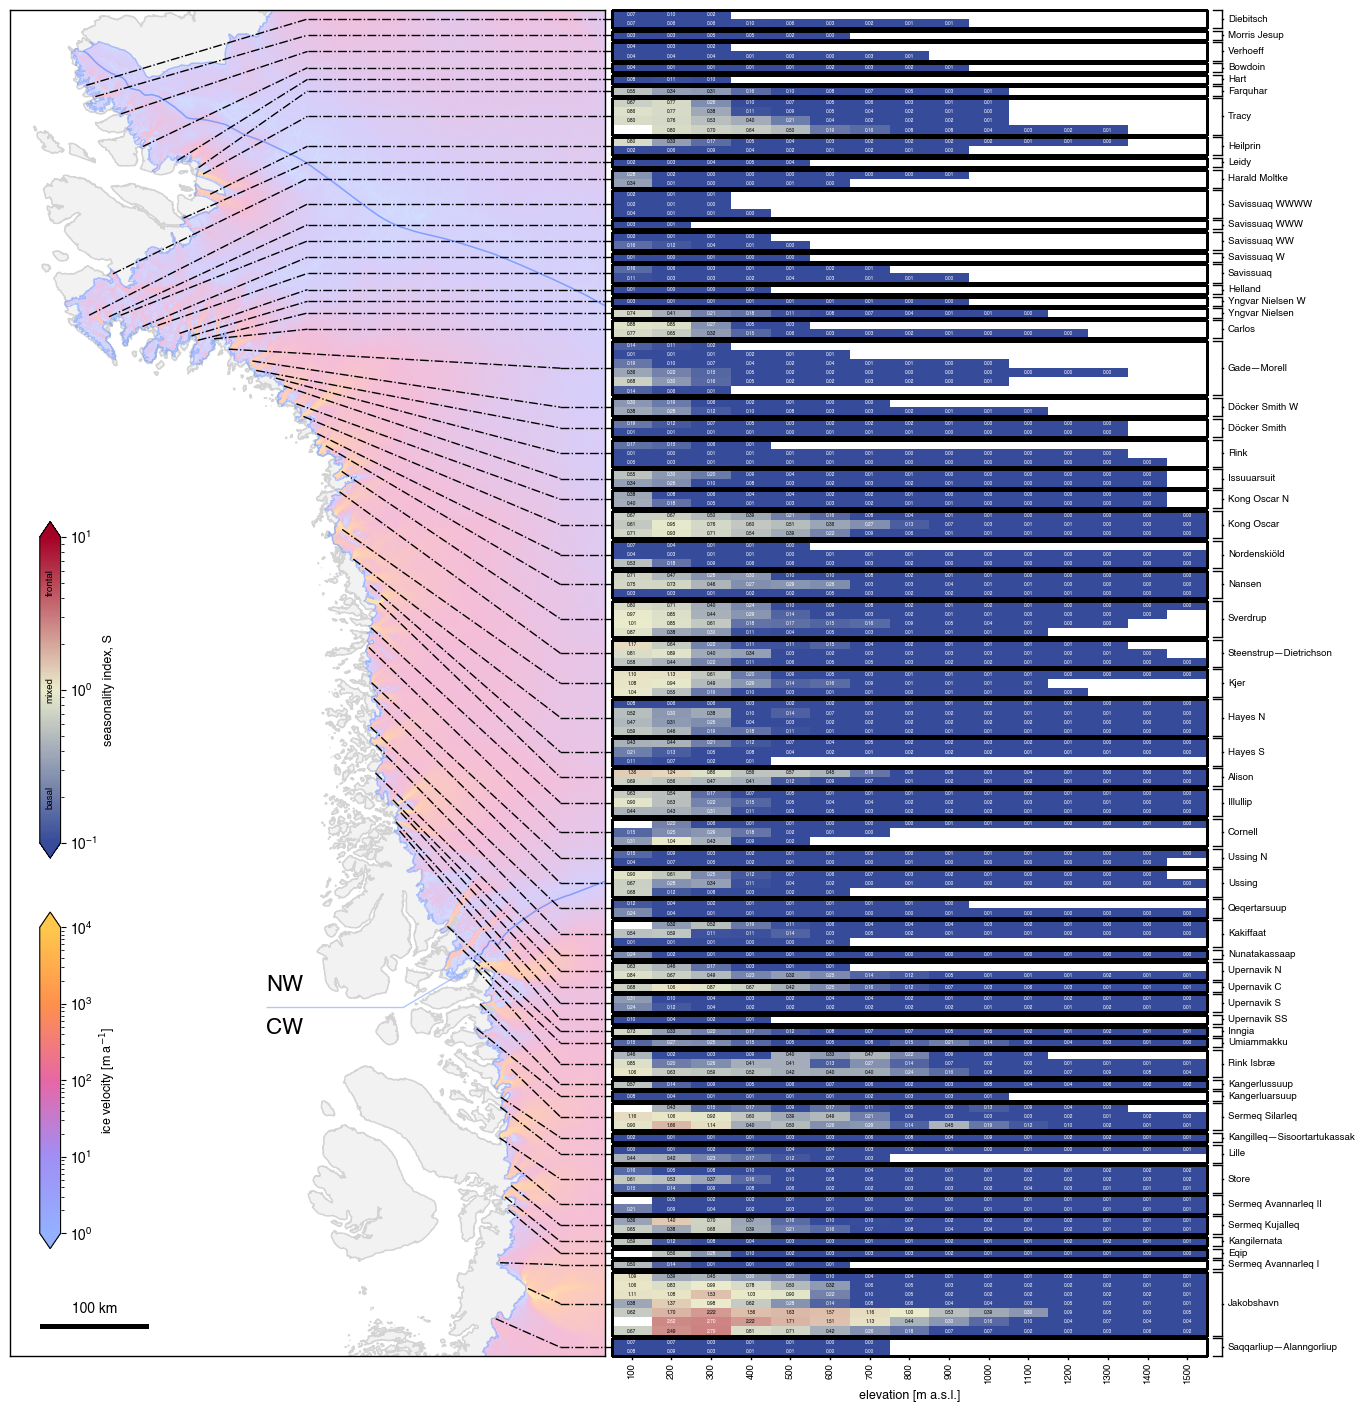

In [4]:
#test map without Mouginot basins

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from matplotlib import patches as mpatches
from math import ceil
from shapely.geometry import mapping
import rasterio.mask as rmask
from shapely.geometry import Point

# === Global font: Helvetica ===
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['mathtext.fontset'] = 'dejavusans'

# --- Paths ---
os.chdir("/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Jess ITS_LIVE v2/Map")
out_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap"
os.makedirs(out_dir, exist_ok=True)

heat_csv  = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric1.csv"
picks_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/New Points v3/Flowlines of Interest/Picks"

# --- Map data ---
_ = pd.read_csv("2016_20_hmm.csv")  # legacy
outline_gdf     = gpd.read_file("NW_CW_outline.shp").to_crs("EPSG:3413")
outline_big_gdf = gpd.read_file("NW_CW_SW_NO_outline.shp").to_crs("EPSG:3413")
greenland_gdf   = gpd.read_file("greenland_outlines.shp").to_crs("EPSG:3413")

minx, miny, maxx, maxy = outline_gdf.total_bounds
buffer = 50000
xmin = minx - (buffer*1)
xmax = maxx - (buffer*8)
ymin = miny + buffer
ymax = maxy + buffer
greenland_clipped = greenland_gdf.cx[xmin:xmax, ymin:ymax]

# --- Colour maps & norms ---
heat_cmap   = mcolors.LinearSegmentedColormap.from_list("heat_cmap", ["#364B9A", "#EAECCC", "#A50026"])
driver_norm = LogNorm(vmin=0.1, vmax=10)

custom_cmap = LinearSegmentedColormap.from_list("custom_log_cmap",
                                                ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"])
def lighten_color(c, amount=0.3):
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(c)
    return (1 - (1-r)*(1-amount), 1 - (1-g)*(1-amount), 1 - (1-b)*(1-amount))
light_cmap   = LinearSegmentedColormap.from_list(
    "light_log_cmap",
    [lighten_color(c) for c in ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]]
)
velocity_norm = LogNorm(vmin=1, vmax=10000)

# --- Heatmap data ---
hm_df = pd.read_csv(heat_csv)
for col in ["glacier_ID", "flowline_ID", "feature_ID"]:
    if col in hm_df.columns:
        hm_df[col] = pd.to_numeric(hm_df[col], errors='coerce')

elev_cols = [c for c in hm_df.columns if re.fullmatch(r"\d+", str(c))]
elev_cols = sorted(elev_cols, key=lambda x: int(x))
hm_df[elev_cols] = hm_df[elev_cols].apply(pd.to_numeric, errors='coerce')

# order: glacier_ID ↑, flowline_ID ↑; top row = lowest glacier_ID
hm_df_sorted = hm_df.sort_values(["glacier_ID", "flowline_ID"],
                                 ascending=[True, True]).reset_index(drop=True)

# --- Match heatmap box to map box ---
map_width  = xmax - xmin
map_height = ymax - ymin

num_cells = 15
cell_size = map_width / num_cells
n_rows    = len(hm_df_sorted)

groups      = hm_df_sorted["glacier_ID"].to_numpy()
unique_gids = pd.unique(groups)
ngaps       = max(0, len(unique_gids) - 1)

# subgroup gaps
nominal_row_h  = map_height / max(1, n_rows)
gap_thin       = 0.25 * nominal_row_h
total_gap_h    = gap_thin * ngaps
if total_gap_h > 0.15 * map_height:
    gap_thin = (0.15 * map_height) / max(1, ngaps)
    total_gap_h = gap_thin * ngaps

bar_height = (map_height - total_gap_h) / max(1, n_rows)

# y0 for each row including group gaps
y0_list = []
acc_gap = 0.0
prev_gid = None
for idx, gid in enumerate(groups):
    if idx > 0 and gid != prev_gid:
        acc_gap += gap_thin
    y0_list.append(idx * bar_height + acc_gap)
    prev_gid = gid
y0_list = np.array(y0_list)

hm_x0, hm_y0 = 0.0, 0.0
hm_x1, hm_y1 = map_width, map_height

# --- Line widths (consistency) ---
MAP_LINE_W       = 1.0
GROUP_LINE_W     = MAP_LINE_W
BRACKET_LINE_W   = GROUP_LINE_W
CONNECT_W        = MAP_LINE_W   # connectors

# --- Figure / layout (equal panel widths) ---
fig_w = 14.0
width_ratios = [1.0, 1.0]
map_frac = width_ratios[0] / sum(width_ratios)
fig_h = max(8.0, fig_w * map_frac * (map_height / map_width))

fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=width_ratios, wspace=0.0)
fig.subplots_adjust(left=0.06, right=0.94, top=0.98, bottom=0.13, wspace=0.0)

ax_map  = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])

# Ensure the heatmap axes patch hides anything behind it (e.g., bridge line)
ax_heat.patch.set_facecolor('white')
ax_heat.patch.set_alpha(1.0)
ax_heat.patch.set_zorder(20)

# =========================
# MAP (left) — grey shading outside outline + clipped opaque raster
# =========================
# 0) Light-grey fill only where outline_big_gdf has no data (inside Greenland)
try:
    gap_geom = greenland_clipped.unary_union.difference(outline_big_gdf.unary_union)
    gap_gdf  = gpd.GeoDataFrame(geometry=[gap_geom], crs=greenland_clipped.crs)
except Exception:
    # Fallback if unary_union fails
    gap_gdf = gpd.overlay(greenland_clipped, outline_big_gdf, how='difference')

# Draw the gap shading first so everything else sits above it
gap_gdf.plot(ax=ax_map, facecolor='#F2F2F2', edgecolor='none', linewidth=0)

# 1) (Optional) faint land outline below the raster
greenland_clipped.plot(ax=ax_map, edgecolor='lightgrey', facecolor='none', linewidth=MAP_LINE_W)

# 2) Velocity raster clipped to outline_big_gdf (opaque where data exists)
with rasterio.open("v_2022.tif") as src:
    clip_gdf = outline_big_gdf
    if clip_gdf.crs is not None and src.crs is not None:
        if clip_gdf.crs.to_string().upper() != src.crs.to_string().upper():
            clip_gdf = clip_gdf.to_crs(src.crs)

    geoms = [mapping(geom) for geom in clip_gdf.geometry if not geom.is_empty]
    masked, _ = rmask.mask(src, geoms, crop=False, filled=True)  # keep full extent
    data = masked[0].astype(float)

    # Ensure log-safe & transparent outside the outline (and for non-positive values)
    data[data <= 0] = np.nan

    ax_map.imshow(
        data,
        cmap=custom_cmap,
        norm=velocity_norm,
        extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
        origin='upper',
        interpolation='none',
        alpha=0.3
    )

# 3) Outlines over the raster
outline_big_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.5, facecolor='none', linewidth=MAP_LINE_W)

# 4) Map bounds, style, spines
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_aspect('equal')
ax_map.set_title("")
ax_map.set_xticks([]); ax_map.set_yticks([])
ax_map.set_xlabel(""); ax_map.set_ylabel("")
for side in ax_map.spines:
    ax_map.spines[side].set_visible(True)
    ax_map.spines[side].set_linewidth(MAP_LINE_W)
    ax_map.spines[side].set_edgecolor('black')
    ax_map.spines[side].set_zorder(10)

# 5) Scale bar (lower-left, just below the legends) + "NO" label (top-right, previous spot)
scalebar_length = 100_000   # 100 km
scalebar_height = 5000
x_bar = xmin + 0.05 * (xmax - xmin)   # align with legend x
y_bar = ymin + 0.02 * (ymax - ymin)   # a touch above bottom

ax_map.add_patch(plt.Rectangle((x_bar, y_bar),
                               scalebar_length, scalebar_height,
                               facecolor='black', zorder=12))
ax_map.text(x_bar + scalebar_length / 2,
            y_bar + scalebar_height + 7000,
            "100 km", ha='center', va='bottom', fontsize=10, zorder=12)

# 6) Legends (unchanged)
def _add_inmap_axes(ax, rel_left, rel_bottom, rel_width, rel_height):
    bb = ax.get_position()
    return fig.add_axes([bb.x0 + rel_left * bb.width,
                         bb.y0 + rel_bottom * bb.height,
                         rel_width * bb.width,
                         rel_height * bb.height])

cax_vel = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.08, rel_width=0.035, rel_height=0.25)
cax_drv = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.37, rel_width=0.035, rel_height=0.25)

sm_driver = plt.cm.ScalarMappable(norm=driver_norm, cmap=heat_cmap); sm_driver.set_array([])
cbar_drv = plt.colorbar(sm_driver, cax=cax_drv, orientation='vertical', extend='both')
cbar_drv.set_label("seasonality index, S", fontsize=9)
cbar_drv.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_drv.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_drv.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_drv.ax.yaxis.set_minor_formatter(NullFormatter())
cax_drv.text(0.5, 0.85, "frontal", ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.50, "mixed",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.15, "basal",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)

sm_raster = plt.cm.ScalarMappable(norm=velocity_norm, cmap=light_cmap); sm_raster.set_array([])
cbar_vel = plt.colorbar(sm_raster, cax=cax_vel, orientation='vertical', extend='both')
cbar_vel.set_label("ice velocity [m a$^{-1}$]", fontsize=9)
cbar_vel.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_vel.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_vel.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_vel.ax.yaxis.set_minor_formatter(NullFormatter())

# --- Custom 3413 line segments + 'NW'/'CW' labels (match outline_big_gdf style) ---
OL_COLOR = "#648FFF"    # same as outline_big_gdf edgecolor
OL_LW    = MAP_LINE_W   # same width as map outline
OL_ALPHA = 0.5          # same alpha used for outline_big_gdf

# Segment endpoints (in EPSG:3413)
xA, yA = -252750.652, -1989477.458
xB, yB = -296916.769, -2015351.266   # bend point
xC, yC = -423553.783, -2015351.266   # end of horizontal

# Segment 1: A -> B (diagonal)
ax_map.plot([xA, xB], [yA, yB],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Segment 2: B -> C (horizontal)
ax_map.plot([xB, xC], [yB, yC],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Labels "NW" (above) and "CW" (below), centered at the bend point (xB, yB)
# Use a small vertical offset so they don't overlap the line
dy = 10000  # meters; tweak if you want closer/farther
ax_map.text(xC + dy*1.7, yC + dy, "NW", ha='center', va='bottom',
            fontsize=16, color='black', zorder=13)
ax_map.text(xC + dy*1.7, yC - dy, "CW", ha='center', va='top',
            fontsize=16, color='black', zorder=13)

# =========================
# HEATMAP (right)
# =========================
ax_heat.margins(0)
ax_heat.set_aspect('equal')
for side in ax_heat.spines:
    ax_heat.spines[side].set_visible(False)

def _text_color_for_face(rgb_tuple):
    r, g, b, *_ = rgb_tuple if len(rgb_tuple) == 4 else (*rgb_tuple, 1)
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.6 else 'white'

NAME_FONT = 7
VAL_FONT  = max(3.5, NAME_FONT * 0.5)

# cells + numeric values (2 decimals) — higher zorder so they sit above any figure-level bridges
for idx, row in hm_df_sorted.iterrows():
    y0 = y0_list[idx]
    vals = pd.to_numeric(row[elev_cols], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0:
        padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]
        x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                                facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                            facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        ax_heat.text(x + 0.5*cell_size, y0 + 0.5*bar_height, f"{v:.2f}",
                     ha='center', va='center', fontsize=VAL_FONT,
                     color=_text_color_for_face(face_rgba), clip_on=False, zorder=27)

# subgroup outlines (one Rectangle per group) — EXACT bounds
group_bounds = {}  # store [y_top, y_bot] for connectors later
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    group_bounds[int(gid)] = (float(y_top), float(y_bot))

    rect = plt.Rectangle((hm_x0, y_top),
                         (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black',
                         linewidth=GROUP_LINE_W, joinstyle='miter',
                         antialiased=False, clip_on=False, zorder=30)
    ax_heat.add_patch(rect)

# inward-facing brackets + names (shorter arms)
trans_xaxes_ydata = transforms.blended_transform_factory(ax_heat.transAxes, ax_heat.transData)
vline_x     = 1.025
stub_len_ax = 0.015  # shorter arms
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    y_mid = 0.5 * (y_top + y_bot)

    ax_heat.add_line(Line2D([vline_x, vline_x], [y_top, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_top, y_top],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_bot, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    # tiny outward tick in the middle (right side of bracket)
    mid_tick_len = 0.002
    ax_heat.add_line(Line2D([vline_x, vline_x + mid_tick_len], [y_mid, y_mid],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))

    ax_heat.text(vline_x + 0.01, y_mid, str(hm_df_sorted.loc[top_idx, "glacier_name"]),
                 transform=trans_xaxes_ydata, ha='left', va='center',
                 fontsize=NAME_FONT, clip_on=False, zorder=30)

# x-axis ticks & labels
trans_xdata_yaxes = transforms.blended_transform_factory(ax_heat.transData, ax_heat.transAxes)
tick_y0_ax, tick_y1_ax = -0.002, -0.000
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                            transform=trans_xdata_yaxes, color='black',
                            linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.text(cx, -0.005, str(col),
                 transform=trans_xdata_yaxes, ha='center', va='top',
                 fontsize=7, rotation=90, clip_on=False, zorder=30)
ax_heat.text(0.5, -0.025, "elevation [m a.s.l.]",
             transform=ax_heat.transAxes, ha='center', va='top',
             fontsize=9, clip_on=False, zorder=30)

# limits; top = lowest glacier_ID
ax_heat.set_xlim(hm_x0, hm_x0 + map_width)
ax_heat.set_ylim(hm_y0, hm_y0 + map_height)
ax_heat.invert_yaxis()
ax_heat.set_xticks([]); ax_heat.set_yticks([])
ax_heat.set_xlabel(""); ax_heat.set_ylabel("")

# === Helper: get the N-th coordinate from a GeoJSON in EPSG:3413 (1-based; clamps to last) ===
def _nth_xy_3413(geojson_path, n=1):
    try:
        gdf = gpd.read_file(geojson_path)
    except Exception:
        return None
    try:
        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:3413")
        elif str(gdf.crs).upper() != "EPSG:3413":
            gdf = gdf.to_crs("EPSG:3413")
    except Exception:
        pass
    if len(gdf) == 0 or gdf.geometry.is_empty.all():
        return None

    def _collect_coords(geom):
        coords = []
        try:
            gt = geom.geom_type
        except Exception:
            gt = None
        if hasattr(geom, "coords"):
            coords.extend(list(geom.coords))
        if gt == "Polygon":
            try:
                coords.extend(list(geom.exterior.coords))
            except Exception:
                pass
        if hasattr(geom, "geoms"):
            try:
                for g in geom.geoms:
                    coords.extend(_collect_coords(g))
            except Exception:
                pass
        return coords

    geom = gdf.geometry.iloc[0]
    coords = _collect_coords(geom)
    if len(coords) == 0:
        c = geom.representative_point()
        return (c.x, c.y)

    idx = max(0, min(len(coords) - 1, n - 1))
    x0, y0 = coords[idx]
    return (float(x0), float(y0))

# Precompute flowline lists per feature_ID
fl_dict = {}
if "feature_ID" in hm_df.columns:
    for fid, sub in hm_df.groupby("feature_ID"):
        try:
            arr = np.sort(sub["flowline_ID"].dropna().astype(int).unique())
            if len(arr) > 0:
                fl_dict[int(fid)] = arr
        except Exception:
            continue

# === Keep panels tight ===
plt.draw()
mb = ax_map.get_position()
hb = ax_heat.get_position()
gap_eps = 0.005
ax_heat.set_position([mb.x1 + gap_eps, hb.y0, hb.width, hb.height])

# === MAP↔HEATMAP dotted connectors; SPECIAL_NTH for coordinate choice; bridge drawn BEHIND the heatmap ===
for gid in unique_gids:
    gid_int = int(gid)
    if gid_int not in group_bounds:
        continue

    sub_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid_int]
    if "feature_ID" in sub_gid.columns and sub_gid["feature_ID"].notna().any():
        feat_counts = sub_gid["feature_ID"].dropna().astype(int).value_counts()
        chosen_fid  = int(feat_counts.index[0])
    else:
        continue

    if chosen_fid in fl_dict and len(fl_dict[chosen_fid]) > 0:
        fls = fl_dict[chosen_fid]
        idx_mid = ceil(len(fls)/2) - 1
        chosen_fl = int(fls[idx_mid])
    else:
        fls_sub = np.sort(sub_gid["flowline_ID"].dropna().astype(int).unique())
        if len(fls_sub) == 0:
            continue
        idx_mid = ceil(len(fls_sub)/2) - 1
        chosen_fl = int(fls_sub[idx_mid])

    # Glaciers that should use the N-th coordinate (1-based) from their GeoJSON
    SPECIAL_NTH = {
        57: 30,
        53: 45,
        49: 50,
        30: 30,
        13: 100,
        10: 20,
        7: 10,
        18: 100,
        # add more here if needed, e.g. 50: 100, 12: 100
    }

    gj_path = os.path.join(picks_dir, f"gl_{chosen_fid}_{chosen_fl}.geojson")
    nth = SPECIAL_NTH.get(gid_int, 1)
    pt = _nth_xy_3413(gj_path, n=nth)
    if pt is None:
        continue
    px, py = pt

    y_top, y_bot = group_bounds[gid_int]
    y_mid_heat = 0.5*(y_top + y_bot)
    y_mid_map  = ymax - y_mid_heat

    map_w = (xmax - xmin)
    if 1 <= gid_int <= 21:
        bend_frac = 0.50
    elif 22 <= gid_int <= 60:
        bend_frac = 0.925
    elif 61 <= gid_int <= 63:
        bend_frac = 0.925
    else:
        bend_frac = 1.00

    x_bend = xmin + bend_frac * map_w

    # --- dotted connectors on the MAP (use BUTT caps so ends don't overhang)
    ax_map.plot([px, x_bend], [py, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)
    ax_map.plot([x_bend, xmax], [y_mid_map, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)

    # --- dotted horizontal bridge across the gap — draw BEHIND heatmap and slightly short
    fig_w_in = fig.get_size_inches()[0]
    eps_fig  = (CONNECT_W / 72.0) / fig_w_in  # ~1 pt in figure fraction
    y_norm   = (y_mid_map - ymin) / (ymax - ymin)
    y_fig    = mb.y0 + y_norm * mb.height
    x_left   = mb.x1
    x_right  = hb.x0
    x_right_adj = x_right - eps_fig  # stop just before the heatmap edge

    bridge = Line2D([x_left, x_right_adj], [y_fig, y_fig],
                    transform=fig.transFigure,
                    color='black', linewidth=CONNECT_W, linestyle='-.',
                    solid_capstyle='butt', dash_capstyle='butt',
                    zorder=-1)  # behind the heatmap axes patch & artists
    fig.add_artist(bridge)

# --- Save ---
pdf_path = os.path.join(out_dir, "map_heatmap_connect.pdf")
jpg_path = os.path.join(out_dir, "map_heatmap_connect.jpg")
fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
fig.savefig(jpg_path, dpi=600, bbox_inches='tight')
print("Saved:", pdf_path, "and", jpg_path)
plt.show()

Saved: /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap_connect_mouginot.pdf and /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_heatmap_connect_mouginot.jpg


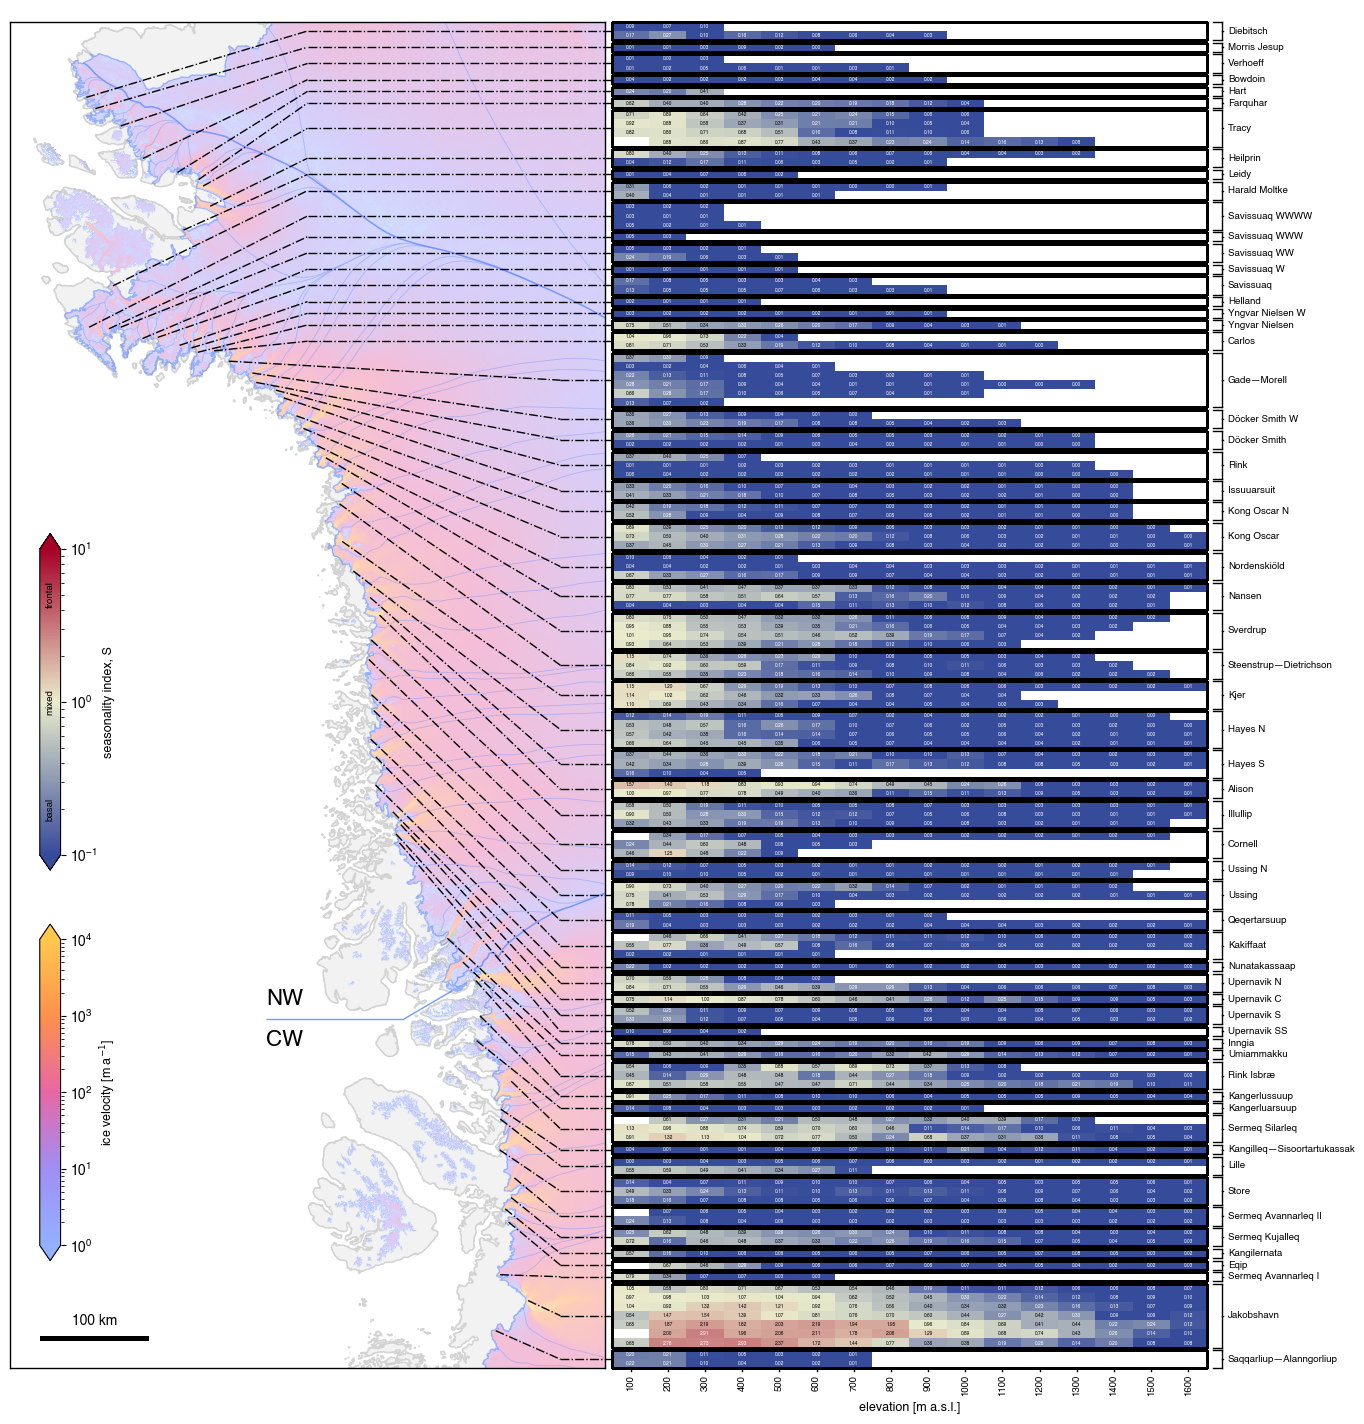

In [ ]:
#test map with Mouginot basins

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from matplotlib import patches as mpatches
from math import ceil
from shapely.geometry import mapping
import rasterio.mask as rmask
from shapely.geometry import Point

# === Global font: Helvetica ===
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['mathtext.fontset'] = 'dejavusans'

# --- Paths ---
os.chdir("/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Jess ITS_LIVE v2/Map")
out_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap"
os.makedirs(out_dir, exist_ok=True)

heat_csv  = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric3.csv"
picks_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/New Points v3/Flowlines of Interest/Picks"

# --- Map data ---
_ = pd.read_csv("2016_20_hmm.csv")  # legacy
outline_gdf     = gpd.read_file("NW_CW_outline.shp").to_crs("EPSG:3413")
outline_big_gdf = gpd.read_file("NW_CW_SW_NO_outline.shp").to_crs("EPSG:3413")
mouginot_gdf    = gpd.read_file("NW_CW_Mouginot_Sectors.shp").to_crs("EPSG:3413")  # NEW
greenland_gdf   = gpd.read_file("greenland_outlines.shp").to_crs("EPSG:3413")

minx, miny, maxx, maxy = outline_gdf.total_bounds
buffer = 50000
xmin = minx - (buffer*1)
xmax = maxx - (buffer*8)
ymin = miny + buffer
ymax = maxy + buffer
greenland_clipped = greenland_gdf.cx[xmin:xmax, ymin:ymax]

# --- Colour maps & norms ---
heat_cmap   = mcolors.LinearSegmentedColormap.from_list("heat_cmap", ["#364B9A", "#EAECCC", "#A50026"])
driver_norm = LogNorm(vmin=0.1, vmax=10)

custom_cmap = LinearSegmentedColormap.from_list("custom_log_cmap",
                                                ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"])
def lighten_color(c, amount=0.3):
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(c)
    return (1 - (1-r)*(1-amount), 1 - (1-g)*(1-amount), 1 - (1-b)*(1-amount))
light_cmap   = LinearSegmentedColormap.from_list(
    "light_log_cmap",
    [lighten_color(c) for c in ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]]
)
velocity_norm = LogNorm(vmin=1, vmax=10000)

# --- Heatmap data ---
hm_df = pd.read_csv(heat_csv)
for col in ["glacier_ID", "flowline_ID", "feature_ID"]:
    if col in hm_df.columns:
        hm_df[col] = pd.to_numeric(hm_df[col], errors='coerce')

elev_cols = [c for c in hm_df.columns if re.fullmatch(r"\d+", str(c))]
elev_cols = sorted(elev_cols, key=lambda x: int(x))
hm_df[elev_cols] = hm_df[elev_cols].apply(pd.to_numeric, errors='coerce')

# order: glacier_ID ↑, flowline_ID ↑; top row = lowest glacier_ID
hm_df_sorted = hm_df.sort_values(["glacier_ID", "flowline_ID"],
                                 ascending=[True, True]).reset_index(drop=True)

# --- Match heatmap box to map box ---
map_width  = xmax - xmin
map_height = ymax - ymin

num_cells = 16
cell_size = map_width / num_cells
n_rows    = len(hm_df_sorted)

groups      = hm_df_sorted["glacier_ID"].to_numpy()
unique_gids = pd.unique(groups)
ngaps       = max(0, len(unique_gids) - 1)

# subgroup gaps
nominal_row_h  = map_height / max(1, n_rows)
gap_thin       = 0.25 * nominal_row_h
total_gap_h    = gap_thin * ngaps
if total_gap_h > 0.15 * map_height:
    gap_thin = (0.15 * map_height) / max(1, ngaps)
    total_gap_h = gap_thin * ngaps

bar_height = (map_height - total_gap_h) / max(1, n_rows)

# y0 for each row including group gaps
y0_list = []
acc_gap = 0.0
prev_gid = None
for idx, gid in enumerate(groups):
    if idx > 0 and gid != prev_gid:
        acc_gap += gap_thin
    y0_list.append(idx * bar_height + acc_gap)
    prev_gid = gid
y0_list = np.array(y0_list)

hm_x0, hm_y0 = 0.0, 0.0
hm_x1, hm_y1 = map_width, map_height

# --- Line widths (consistency) ---
MAP_LINE_W       = 1.0
GROUP_LINE_W     = MAP_LINE_W
BRACKET_LINE_W   = GROUP_LINE_W
CONNECT_W        = MAP_LINE_W   # connectors

# --- Figure / layout (equal panel widths) ---
fig_w = 14.0
width_ratios = [1.0, 1.0]
map_frac = width_ratios[0] / sum(width_ratios)
fig_h = max(8.0, fig_w * map_frac * (map_height / map_width))

fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=width_ratios, wspace=0.0)
fig.subplots_adjust(left=0.06, right=0.94, top=0.98, bottom=0.13, wspace=0.0)

ax_map  = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])

# Ensure the heatmap axes patch hides anything behind it (e.g., bridge line)
ax_heat.patch.set_facecolor('white')
ax_heat.patch.set_alpha(1.0)
ax_heat.patch.set_zorder(20)

# =========================
# MAP (left) — grey shading outside outline_big_gdf + raster clipped to Mouginot basins
# =========================
# Set outline widths

# 0) Light-grey fill only where outline_big_gdf has no data (inside Greenland)
try:
    gap_geom = greenland_clipped.unary_union.difference(mouginot_gdf.unary_union)
    gap_gdf  = gpd.GeoDataFrame(geometry=[gap_geom], crs=greenland_clipped.crs)
except Exception:
    gap_gdf = gpd.overlay(greenland_clipped, outline_big_gdf, how='difference')

# Draw the gap shading first so everything else sits above it
gap_gdf.plot(ax=ax_map, facecolor='#F2F2F2', edgecolor='none', linewidth=0)

# 1) (Optional) faint land outline below the raster
greenland_clipped.plot(ax=ax_map, edgecolor='lightgrey', facecolor='none', linewidth=MAP_LINE_W)

# 2) Velocity raster clipped to Mouginot basins (opaque where valid)
with rasterio.open("v_2022.tif") as src:
    clip_gdf = mouginot_gdf
    if clip_gdf.crs is not None and src.crs is not None:
        if clip_gdf.crs.to_string().upper() != src.crs.to_string().upper():
            clip_gdf = clip_gdf.to_crs(src.crs)

    geoms = [mapping(geom) for geom in clip_gdf.geometry if not geom.is_empty]
    masked, _ = rmask.mask(src, geoms, crop=False, filled=True)  # keep full extent
    data = masked[0].astype(float)
    data[data <= 0] = np.nan

    ax_map.imshow(
        data,
        cmap=custom_cmap,
        norm=velocity_norm,
        extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
        origin='upper',
        interpolation='none',
        alpha=0.3  # keep your existing look
    )

# 3) Outlines over the raster (same color/type, different widths)
mouginot_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.25, facecolor='none', linewidth=MAP_LINE_W*0.5)
outline_big_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.5, facecolor='none', linewidth=MAP_LINE_W)

# 4) Map bounds, style, spines
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_aspect('equal')
ax_map.set_title("")
ax_map.set_xticks([]); ax_map.set_yticks([])
ax_map.set_xlabel(""); ax_map.set_ylabel("")
for side in ax_map.spines:
    ax_map.spines[side].set_visible(True)
    ax_map.spines[side].set_linewidth(MAP_LINE_W)
    ax_map.spines[side].set_edgecolor('black')
    ax_map.spines[side].set_zorder(10)

# 5) Scale bar + “NO” label (unchanged)
scalebar_length = 100_000   # 100 km
scalebar_height = 5000
x_bar = xmin + 0.05 * (xmax - xmin)
y_bar = ymin + 0.02 * (ymax - ymin)
ax_map.add_patch(plt.Rectangle((x_bar, y_bar), scalebar_length, scalebar_height, facecolor='black', zorder=12))
ax_map.text(x_bar + scalebar_length / 2, y_bar + scalebar_height + 7000, "100 km", ha='center', va='bottom', fontsize=10, zorder=12)

x_bar_old = xmax - scalebar_length - 50_000
y_bar_old = ymax - 70_000

# 6) Legends (unchanged)
def _add_inmap_axes(ax, rel_left, rel_bottom, rel_width, rel_height):
    bb = ax.get_position()
    return fig.add_axes([bb.x0 + rel_left * bb.width,
                         bb.y0 + rel_bottom * bb.height,
                         rel_width * bb.width,
                         rel_height * bb.height])

cax_vel = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.08, rel_width=0.035, rel_height=0.25)
cax_drv = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.37, rel_width=0.035, rel_height=0.25)

sm_driver = plt.cm.ScalarMappable(norm=driver_norm, cmap=heat_cmap); sm_driver.set_array([])
cbar_drv = plt.colorbar(sm_driver, cax=cax_drv, orientation='vertical', extend='both')
cbar_drv.set_label("seasonality index, S", fontsize=9)
cbar_drv.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_drv.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_drv.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_drv.ax.yaxis.set_minor_formatter(NullFormatter())
cax_drv.text(0.5, 0.85, "frontal", ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.50, "mixed",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.15, "basal",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)

sm_raster = plt.cm.ScalarMappable(norm=velocity_norm, cmap=light_cmap); sm_raster.set_array([])
cbar_vel = plt.colorbar(sm_raster, cax=cax_vel, orientation='vertical', extend='both')
cbar_vel.set_label("ice velocity [m a$^{-1}$]", fontsize=9)
cbar_vel.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_vel.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_vel.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_vel.ax.yaxis.set_minor_formatter(NullFormatter())

# --- Custom 3413 line segments + 'NW'/'CW' labels (match outline_big_gdf style) ---
OL_COLOR = "#648FFF"
OL_LW    = MAP_LINE_W   # match the thicker outline_big_gdf width
OL_ALPHA = 0.9

# Segment endpoints (in EPSG:3413)
xA, yA = -252750.652, -1989477.458
xB, yB = -296916.769, -2015351.266   # bend point
xC, yC = -423553.783, -2015351.266   # end of horizontal

# Segment 1: A -> B (diagonal)
ax_map.plot([xA, xB], [yA, yB],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Segment 2: B -> C (horizontal)
ax_map.plot([xB, xC], [yB, yC],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Labels "NW" (above) and "CW" (below), centered at the bend point (xB, yB)
# Use a small vertical offset so they don't overlap the line
dy = 10000  # meters; tweak if you want closer/farther
ax_map.text(xC + dy*1.7, yC + dy*0.8, "NW", ha='center', va='bottom',
            fontsize=16, color='black', zorder=13)
ax_map.text(xC + dy*1.7, yC - dy, "CW", ha='center', va='top',
            fontsize=16, color='black', zorder=13)

# =========================
# HEATMAP (right)
# =========================
ax_heat.margins(0)
ax_heat.set_aspect('equal')
for side in ax_heat.spines:
    ax_heat.spines[side].set_visible(False)

def _text_color_for_face(rgb_tuple):
    r, g, b, *_ = rgb_tuple if len(rgb_tuple) == 4 else (*rgb_tuple, 1)
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.6 else 'white'

NAME_FONT = 7
VAL_FONT  = max(3.5, NAME_FONT * 0.5)

# cells + numeric values (2 decimals) — higher zorder so they sit above any figure-level bridges
for idx, row in hm_df_sorted.iterrows():
    y0 = y0_list[idx]
    vals = pd.to_numeric(row[elev_cols], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0:
        padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]
        x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                                facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                            facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        ax_heat.text(x + 0.5*cell_size, y0 + 0.5*bar_height, f"{v:.2f}",
                     ha='center', va='center', fontsize=VAL_FONT,
                     color=_text_color_for_face(face_rgba), clip_on=False, zorder=27)

# subgroup outlines (one Rectangle per group) — EXACT bounds
group_bounds = {}  # store [y_top, y_bot] for connectors later
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    group_bounds[int(gid)] = (float(y_top), float(y_bot))

    rect = plt.Rectangle((hm_x0, y_top),
                         (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black',
                         linewidth=GROUP_LINE_W, joinstyle='miter',
                         antialiased=False, clip_on=False, zorder=30)
    ax_heat.add_patch(rect)

# inward-facing brackets + names (shorter arms)
trans_xaxes_ydata = transforms.blended_transform_factory(ax_heat.transAxes, ax_heat.transData)
vline_x     = 1.025
stub_len_ax = 0.015  # shorter arms
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    y_mid = 0.5 * (y_top + y_bot)

    ax_heat.add_line(Line2D([vline_x, vline_x], [y_top, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_top, y_top],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_bot, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    # tiny outward tick in the middle (right side of bracket)
    mid_tick_len = 0.002
    ax_heat.add_line(Line2D([vline_x, vline_x + mid_tick_len], [y_mid, y_mid],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))

    ax_heat.text(vline_x + 0.01, y_mid, str(hm_df_sorted.loc[top_idx, "glacier_name"]),
                 transform=trans_xaxes_ydata, ha='left', va='center',
                 fontsize=NAME_FONT, clip_on=False, zorder=30)

# x-axis ticks & labels
trans_xdata_yaxes = transforms.blended_transform_factory(ax_heat.transData, ax_heat.transAxes)
tick_y0_ax, tick_y1_ax = -0.002, -0.000
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                            transform=trans_xdata_yaxes, color='black',
                            linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.text(cx, -0.005, str(col),
                 transform=trans_xdata_yaxes, ha='center', va='top',
                 fontsize=7, rotation=90, clip_on=False, zorder=30)
ax_heat.text(0.5, -0.025, "elevation [m a.s.l.]",
             transform=ax_heat.transAxes, ha='center', va='top',
             fontsize=9, clip_on=False, zorder=30)

# Title above the heatmap (same style as the x-axis label, but white)
HEATMAP_TITLE = "Budd m=6"  # change text if you prefer
ax_heat.text(0.5, 1.0, HEATMAP_TITLE,
             transform=ax_heat.transAxes, ha='center', va='bottom',
             fontsize=9, color='white', clip_on=False, zorder=30)

# limits; top = lowest glacier_ID
ax_heat.set_xlim(hm_x0, hm_x0 + map_width)
ax_heat.set_ylim(hm_y0, hm_y0 + map_height)
ax_heat.invert_yaxis()
ax_heat.set_xticks([]); ax_heat.set_yticks([])
ax_heat.set_xlabel(""); ax_heat.set_ylabel("")

# === Helper: get the N-th coordinate from a GeoJSON in EPSG:3413 (1-based; clamps to last) ===
def _nth_xy_3413(geojson_path, n=1):
    try:
        gdf = gpd.read_file(geojson_path)
    except Exception:
        return None
    try:
        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:3413")
        elif str(gdf.crs).upper() != "EPSG:3413":
            gdf = gdf.to_crs("EPSG:3413")
    except Exception:
        pass
    if len(gdf) == 0 or gdf.geometry.is_empty.all():
        return None

    def _collect_coords(geom):
        coords = []
        try:
            gt = geom.geom_type
        except Exception:
            gt = None
        if hasattr(geom, "coords"):
            coords.extend(list(geom.coords))
        if gt == "Polygon":
            try:
                coords.extend(list(geom.exterior.coords))
            except Exception:
                pass
        if hasattr(geom, "geoms"):
            try:
                for g in geom.geoms:
                    coords.extend(_collect_coords(g))
            except Exception:
                pass
        return coords

    geom = gdf.geometry.iloc[0]
    coords = _collect_coords(geom)
    if len(coords) == 0:
        c = geom.representative_point()
        return (c.x, c.y)

    idx = max(0, min(len(coords) - 1, n - 1))
    x0, y0 = coords[idx]
    return (float(x0), float(y0))

# Precompute flowline lists per feature_ID
fl_dict = {}
if "feature_ID" in hm_df.columns:
    for fid, sub in hm_df.groupby("feature_ID"):
        try:
            arr = np.sort(sub["flowline_ID"].dropna().astype(int).unique())
            if len(arr) > 0:
                fl_dict[int(fid)] = arr
        except Exception:
            continue

# === Keep panels tight ===
plt.draw()
mb = ax_map.get_position()
hb = ax_heat.get_position()
gap_eps = 0.005
ax_heat.set_position([mb.x1 + gap_eps, hb.y0, hb.width, hb.height])

# === MAP↔HEATMAP dotted connectors; SPECIAL_NTH for coordinate choice; bridge drawn BEHIND the heatmap ===
for gid in unique_gids:
    gid_int = int(gid)
    if gid_int not in group_bounds:
        continue

    sub_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid_int]
    if "feature_ID" in sub_gid.columns and sub_gid["feature_ID"].notna().any():
        feat_counts = sub_gid["feature_ID"].dropna().astype(int).value_counts()
        chosen_fid  = int(feat_counts.index[0])
    else:
        continue

    if chosen_fid in fl_dict and len(fl_dict[chosen_fid]) > 0:
        fls = fl_dict[chosen_fid]
        idx_mid = ceil(len(fls)/2) - 1
        chosen_fl = int(fls[idx_mid])
    else:
        fls_sub = np.sort(sub_gid["flowline_ID"].dropna().astype(int).unique())
        if len(fls_sub) == 0:
            continue
        idx_mid = ceil(len(fls_sub)/2) - 1
        chosen_fl = int(fls_sub[idx_mid])

    # Glaciers that should use the N-th coordinate (1-based) from their GeoJSON
    SPECIAL_NTH = {
        57: 30,
        53: 45,
        49: 50,
        30: 30,
        13: 100,
        10: 20,
        7: 10,
        18: 100,
        # add more here if needed, e.g. 50: 100, 12: 100
    }

    gj_path = os.path.join(picks_dir, f"gl_{chosen_fid}_{chosen_fl}.geojson")
    nth = SPECIAL_NTH.get(gid_int, 1)
    pt = _nth_xy_3413(gj_path, n=nth)
    if pt is None:
        continue
    px, py = pt

    y_top, y_bot = group_bounds[gid_int]
    y_mid_heat = 0.5*(y_top + y_bot)
    y_mid_map  = ymax - y_mid_heat

    map_w = (xmax - xmin)
    if 1 <= gid_int <= 21:
        bend_frac = 0.50
    elif 22 <= gid_int <= 60:
        bend_frac = 0.925
    elif 61 <= gid_int <= 63:
        bend_frac = 0.925
    else:
        bend_frac = 1.00

    x_bend = xmin + bend_frac * map_w

    # --- dotted connectors on the MAP (use BUTT caps so ends don't overhang)
    ax_map.plot([px, x_bend], [py, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)
    ax_map.plot([x_bend, xmax], [y_mid_map, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)

    # --- dotted horizontal bridge across the gap — draw BEHIND heatmap and slightly short
    fig_w_in = fig.get_size_inches()[0]
    eps_fig  = (CONNECT_W / 72.0) / fig_w_in  # ~1 pt in figure fraction
    y_norm   = (y_mid_map - ymin) / (ymax - ymin)
    y_fig    = mb.y0 + y_norm * mb.height
    x_left   = mb.x1
    x_right  = hb.x0
    x_right_adj = x_right - eps_fig  # stop just before the heatmap edge

    bridge = Line2D([x_left, x_right_adj], [y_fig, y_fig],
                    transform=fig.transFigure,
                    color='black', linewidth=CONNECT_W, linestyle='-.',
                    solid_capstyle='butt', dash_capstyle='butt',
                    zorder=-1)  # behind the heatmap axes patch & artists
    fig.add_artist(bridge)

# --- Save ---
pdf_path = os.path.join(out_dir, "map_heatmap_connect_mouginot.pdf")
jpg_path = os.path.join(out_dir, "map_heatmap_connect_mouginot.jpg")
fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
fig.savefig(jpg_path, dpi=600, bbox_inches='tight')
print("Saved:", pdf_path, "and", jpg_path)
plt.show()

Saved: /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_main.pdf and /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_main.jpg


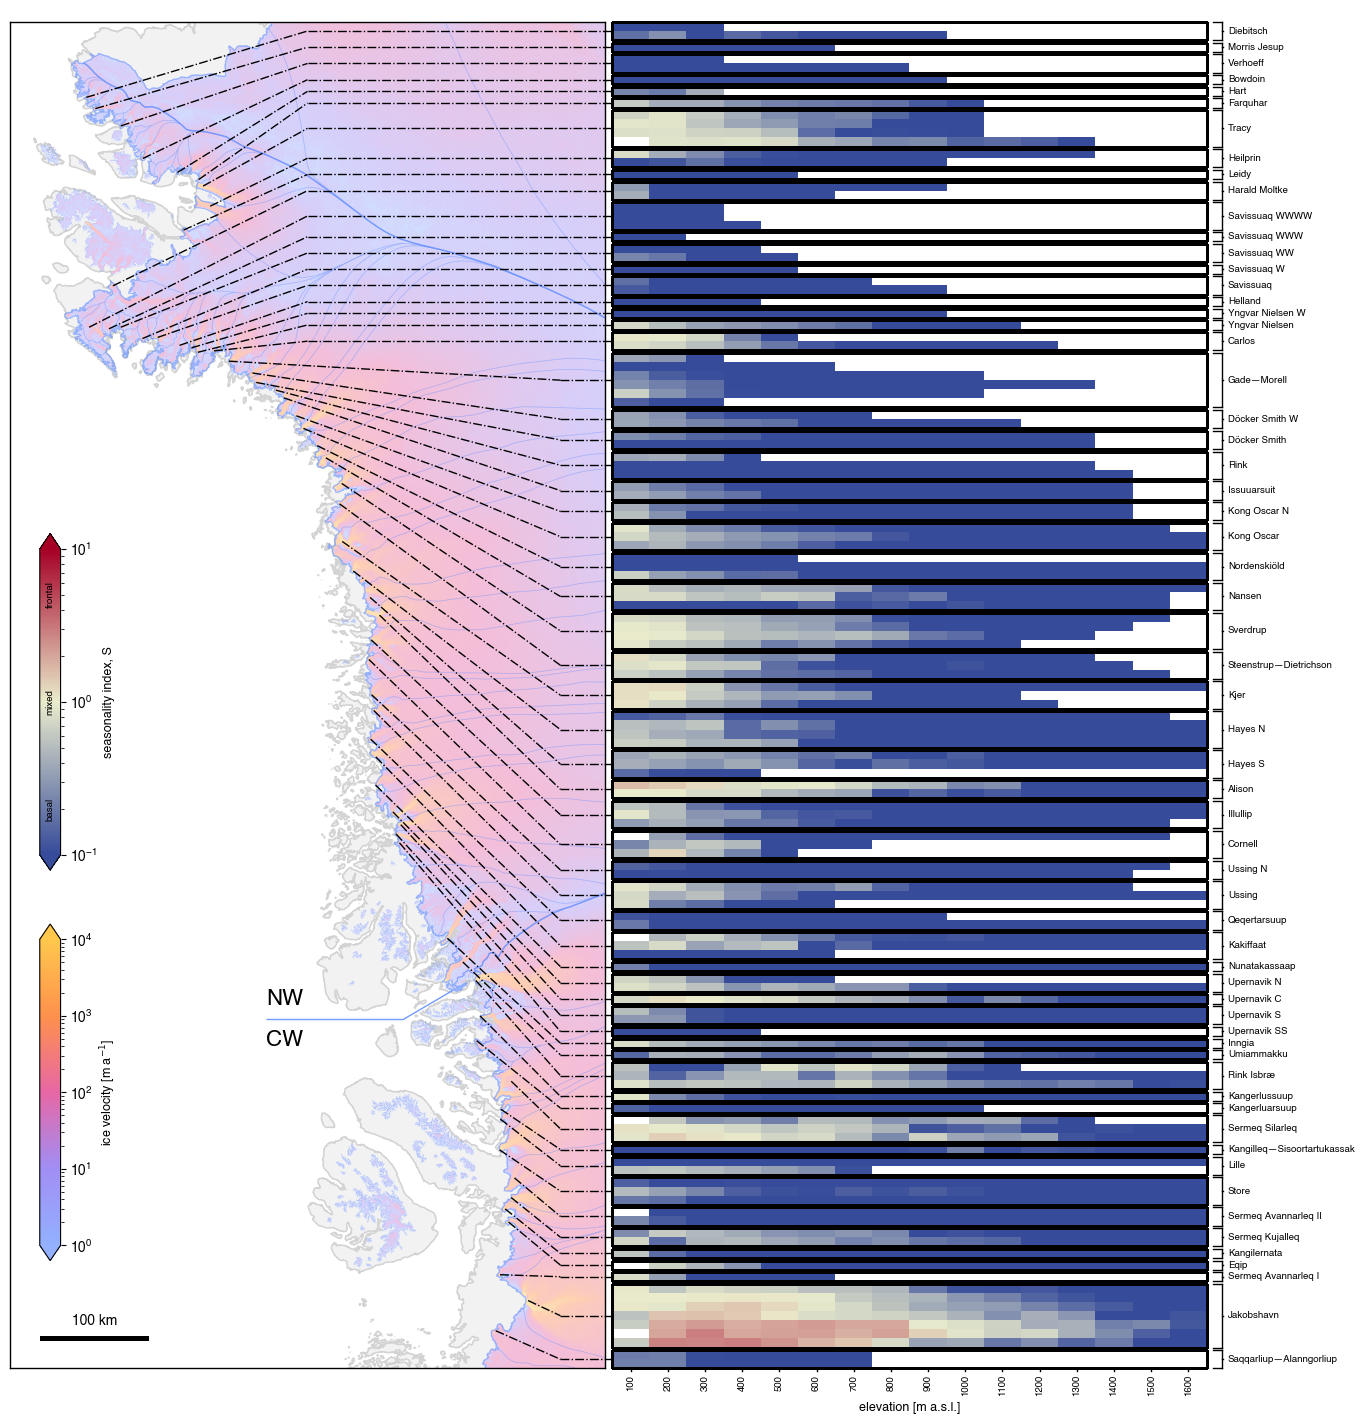

In [5]:
#map for the main text with shortned fric3 results

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from matplotlib import patches as mpatches
from math import ceil
from shapely.geometry import mapping
import rasterio.mask as rmask
from shapely.geometry import Point

SHOW_CELL_VALUES = False

# === Global font: Helvetica ===
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['mathtext.fontset'] = 'dejavusans'

# --- Paths ---
os.chdir("/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Jess ITS_LIVE v2/Map")
out_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap"
os.makedirs(out_dir, exist_ok=True)

heat_csv  = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric3.csv"
picks_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/New Points v3/Flowlines of Interest/Picks"

# --- Map data ---
_ = pd.read_csv("2016_20_hmm.csv")  # legacy
outline_gdf     = gpd.read_file("NW_CW_outline.shp").to_crs("EPSG:3413")
outline_big_gdf = gpd.read_file("NW_CW_SW_NO_outline.shp").to_crs("EPSG:3413")
mouginot_gdf    = gpd.read_file("NW_CW_Mouginot_Sectors.shp").to_crs("EPSG:3413")  # NEW
greenland_gdf   = gpd.read_file("greenland_outlines.shp").to_crs("EPSG:3413")

minx, miny, maxx, maxy = outline_gdf.total_bounds
buffer = 50000
xmin = minx - (buffer*1)
xmax = maxx - (buffer*8)
ymin = miny + buffer
ymax = maxy + buffer
greenland_clipped = greenland_gdf.cx[xmin:xmax, ymin:ymax]

# --- Colour maps & norms ---
heat_cmap   = mcolors.LinearSegmentedColormap.from_list("heat_cmap", ["#364B9A", "#EAECCC", "#A50026"])
driver_norm = LogNorm(vmin=0.1, vmax=10)

custom_cmap = LinearSegmentedColormap.from_list("custom_log_cmap",
                                                ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"])
def lighten_color(c, amount=0.3):
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(c)
    return (1 - (1-r)*(1-amount), 1 - (1-g)*(1-amount), 1 - (1-b)*(1-amount))
light_cmap   = LinearSegmentedColormap.from_list(
    "light_log_cmap",
    [lighten_color(c) for c in ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]]
)
velocity_norm = LogNorm(vmin=1, vmax=10000)

# --- Heatmap data ---
hm_df = pd.read_csv(heat_csv)
for col in ["glacier_ID", "flowline_ID", "feature_ID"]:
    if col in hm_df.columns:
        hm_df[col] = pd.to_numeric(hm_df[col], errors='coerce')

elev_cols = [c for c in hm_df.columns if re.fullmatch(r"\d+", str(c))]
elev_cols = sorted(elev_cols, key=lambda x: int(x))
hm_df[elev_cols] = hm_df[elev_cols].apply(pd.to_numeric, errors='coerce')

# order: glacier_ID ↑, flowline_ID ↑; top row = lowest glacier_ID
hm_df_sorted = hm_df.sort_values(["glacier_ID", "flowline_ID"],
                                 ascending=[True, True]).reset_index(drop=True)

# --- Match heatmap box to map box ---
map_width  = xmax - xmin
map_height = ymax - ymin

num_cells = 16
cell_size = map_width / num_cells
n_rows    = len(hm_df_sorted)

groups      = hm_df_sorted["glacier_ID"].to_numpy()
unique_gids = pd.unique(groups)
ngaps       = max(0, len(unique_gids) - 1)

# subgroup gaps
nominal_row_h  = map_height / max(1, n_rows)
gap_thin       = 0.25 * nominal_row_h
total_gap_h    = gap_thin * ngaps
if total_gap_h > 0.15 * map_height:
    gap_thin = (0.15 * map_height) / max(1, ngaps)
    total_gap_h = gap_thin * ngaps

bar_height = (map_height - total_gap_h) / max(1, n_rows)

# y0 for each row including group gaps
y0_list = []
acc_gap = 0.0
prev_gid = None
for idx, gid in enumerate(groups):
    if idx > 0 and gid != prev_gid:
        acc_gap += gap_thin
    y0_list.append(idx * bar_height + acc_gap)
    prev_gid = gid
y0_list = np.array(y0_list)

hm_x0, hm_y0 = 0.0, 0.0
hm_x1, hm_y1 = map_width, map_height

# --- Line widths (consistency) ---
MAP_LINE_W       = 1.0
GROUP_LINE_W     = MAP_LINE_W
BRACKET_LINE_W   = GROUP_LINE_W
CONNECT_W        = MAP_LINE_W   # connectors

# --- Figure / layout (equal panel widths) ---
fig_w = 14.0
width_ratios = [1.0, 1.0]
map_frac = width_ratios[0] / sum(width_ratios)
fig_h = max(8.0, fig_w * map_frac * (map_height / map_width))

fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=width_ratios, wspace=0.0)
fig.subplots_adjust(left=0.06, right=0.94, top=0.98, bottom=0.13, wspace=0.0)

ax_map  = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])

# Ensure the heatmap axes patch hides anything behind it (e.g., bridge line)
ax_heat.patch.set_facecolor('white')
ax_heat.patch.set_alpha(1.0)
ax_heat.patch.set_zorder(20)

# =========================
# MAP (left) — grey shading outside outline_big_gdf + raster clipped to Mouginot basins
# =========================
# Set outline widths

# 0) Light-grey fill only where outline_big_gdf has no data (inside Greenland)
try:
    gap_geom = greenland_clipped.unary_union.difference(mouginot_gdf.unary_union)
    gap_gdf  = gpd.GeoDataFrame(geometry=[gap_geom], crs=greenland_clipped.crs)
except Exception:
    gap_gdf = gpd.overlay(greenland_clipped, outline_big_gdf, how='difference')

# Draw the gap shading first so everything else sits above it
gap_gdf.plot(ax=ax_map, facecolor='#F2F2F2', edgecolor='none', linewidth=0)

# 1) (Optional) faint land outline below the raster
greenland_clipped.plot(ax=ax_map, edgecolor='lightgrey', facecolor='none', linewidth=MAP_LINE_W)

# 2) Velocity raster clipped to Mouginot basins (opaque where valid)
with rasterio.open("v_2022.tif") as src:
    clip_gdf = mouginot_gdf
    if clip_gdf.crs is not None and src.crs is not None:
        if clip_gdf.crs.to_string().upper() != src.crs.to_string().upper():
            clip_gdf = clip_gdf.to_crs(src.crs)

    geoms = [mapping(geom) for geom in clip_gdf.geometry if not geom.is_empty]
    masked, _ = rmask.mask(src, geoms, crop=False, filled=True)  # keep full extent
    data = masked[0].astype(float)
    data[data <= 0] = np.nan

    ax_map.imshow(
        data,
        cmap=custom_cmap,
        norm=velocity_norm,
        extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
        origin='upper',
        interpolation='none',
        alpha=0.3  # keep your existing look
    )

# 3) Outlines over the raster (same color/type, different widths)
mouginot_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.25, facecolor='none', linewidth=MAP_LINE_W*0.5)
outline_big_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.5, facecolor='none', linewidth=MAP_LINE_W)

# 4) Map bounds, style, spines
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_aspect('equal')
ax_map.set_title("")
ax_map.set_xticks([]); ax_map.set_yticks([])
ax_map.set_xlabel(""); ax_map.set_ylabel("")
for side in ax_map.spines:
    ax_map.spines[side].set_visible(True)
    ax_map.spines[side].set_linewidth(MAP_LINE_W)
    ax_map.spines[side].set_edgecolor('black')
    ax_map.spines[side].set_zorder(10)

# 5) Scale bar + “NO” label (unchanged)
scalebar_length = 100_000   # 100 km
scalebar_height = 5000
x_bar = xmin + 0.05 * (xmax - xmin)
y_bar = ymin + 0.02 * (ymax - ymin)
ax_map.add_patch(plt.Rectangle((x_bar, y_bar), scalebar_length, scalebar_height, facecolor='black', zorder=12))
ax_map.text(x_bar + scalebar_length / 2, y_bar + scalebar_height + 7000, "100 km", ha='center', va='bottom', fontsize=10, zorder=12)

x_bar_old = xmax - scalebar_length - 50_000
y_bar_old = ymax - 70_000

# 6) Legends (unchanged)
def _add_inmap_axes(ax, rel_left, rel_bottom, rel_width, rel_height):
    bb = ax.get_position()
    return fig.add_axes([bb.x0 + rel_left * bb.width,
                         bb.y0 + rel_bottom * bb.height,
                         rel_width * bb.width,
                         rel_height * bb.height])

cax_vel = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.08, rel_width=0.035, rel_height=0.25)
cax_drv = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.37, rel_width=0.035, rel_height=0.25)

sm_driver = plt.cm.ScalarMappable(norm=driver_norm, cmap=heat_cmap); sm_driver.set_array([])
cbar_drv = plt.colorbar(sm_driver, cax=cax_drv, orientation='vertical', extend='both')
cbar_drv.set_label("seasonality index, S", fontsize=9)
cbar_drv.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_drv.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_drv.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_drv.ax.yaxis.set_minor_formatter(NullFormatter())
cax_drv.text(0.5, 0.85, "frontal", ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.50, "mixed",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.15, "basal",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)

sm_raster = plt.cm.ScalarMappable(norm=velocity_norm, cmap=light_cmap); sm_raster.set_array([])
cbar_vel = plt.colorbar(sm_raster, cax=cax_vel, orientation='vertical', extend='both')
cbar_vel.set_label("ice velocity [m a$^{-1}$]", fontsize=9)
cbar_vel.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_vel.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_vel.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_vel.ax.yaxis.set_minor_formatter(NullFormatter())

# --- Custom 3413 line segments + 'NW'/'CW' labels (match outline_big_gdf style) ---
OL_COLOR = "#648FFF"
OL_LW    = MAP_LINE_W   # match the thicker outline_big_gdf width
OL_ALPHA = 0.9

# Segment endpoints (in EPSG:3413)
xA, yA = -252750.652, -1989477.458
xB, yB = -296916.769, -2015351.266   # bend point
xC, yC = -423553.783, -2015351.266   # end of horizontal

# Segment 1: A -> B (diagonal)
ax_map.plot([xA, xB], [yA, yB],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Segment 2: B -> C (horizontal)
ax_map.plot([xB, xC], [yB, yC],
            color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA,
            solid_capstyle='butt', zorder=12)

# Labels "NW" (above) and "CW" (below), centered at the bend point (xB, yB)
# Use a small vertical offset so they don't overlap the line
dy = 10000  # meters; tweak if you want closer/farther
ax_map.text(xC + dy*1.7, yC + dy*0.8, "NW", ha='center', va='bottom',
            fontsize=16, color='black', zorder=13)
ax_map.text(xC + dy*1.7, yC - dy, "CW", ha='center', va='top',
            fontsize=16, color='black', zorder=13)

# =========================
# HEATMAP (right)
# =========================
ax_heat.margins(0)
ax_heat.set_aspect('equal')
for side in ax_heat.spines:
    ax_heat.spines[side].set_visible(False)

def _text_color_for_face(rgb_tuple):
    r, g, b, *_ = rgb_tuple if len(rgb_tuple) == 4 else (*rgb_tuple, 1)
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.6 else 'white'

NAME_FONT = 7
VAL_FONT  = max(3.5, NAME_FONT * 0.5)

# cells + numeric values (2 decimals) — higher zorder so they sit above any figure-level bridges
for idx, row in hm_df_sorted.iterrows():
    y0 = y0_list[idx]
    vals = pd.to_numeric(row[elev_cols], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0:
        padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]
        x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                                facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_heat.add_patch(plt.Rectangle((x, y0), cell_size, bar_height,
                            facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        if SHOW_CELL_VALUES:
            ax_heat.text(x + 0.5*cell_size, y0 + 0.5*bar_height, f"{v:.2f}",
                     ha='center', va='center', fontsize=VAL_FONT,
                     color=_text_color_for_face(face_rgba), clip_on=False, zorder=27)

# subgroup outlines (one Rectangle per group) — EXACT bounds
group_bounds = {}  # store [y_top, y_bot] for connectors later
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    group_bounds[int(gid)] = (float(y_top), float(y_bot))

    rect = plt.Rectangle((hm_x0, y_top),
                         (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black',
                         linewidth=GROUP_LINE_W, joinstyle='miter',
                         antialiased=False, clip_on=False, zorder=30)
    ax_heat.add_patch(rect)

# inward-facing brackets + names (shorter arms)
trans_xaxes_ydata = transforms.blended_transform_factory(ax_heat.transAxes, ax_heat.transData)
vline_x     = 1.025
stub_len_ax = 0.015  # shorter arms
for gid in unique_gids:
    gdf_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min()
    bot_idx = gdf_gid.index.max()
    y_top = y0_list[top_idx]
    y_bot = y0_list[bot_idx] + bar_height
    y_mid = 0.5 * (y_top + y_bot)

    ax_heat.add_line(Line2D([vline_x, vline_x], [y_top, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_top, y_top],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_heat.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_bot, y_bot],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    # tiny outward tick in the middle (right side of bracket)
    mid_tick_len = 0.002
    ax_heat.add_line(Line2D([vline_x, vline_x + mid_tick_len], [y_mid, y_mid],
                            transform=trans_xaxes_ydata, color='black',
                            linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))

    ax_heat.text(vline_x + 0.01, y_mid, str(hm_df_sorted.loc[top_idx, "glacier_name"]),
                 transform=trans_xaxes_ydata, ha='left', va='center',
                 fontsize=NAME_FONT, clip_on=False, zorder=30)

# x-axis ticks & labels
trans_xdata_yaxes = transforms.blended_transform_factory(ax_heat.transData, ax_heat.transAxes)
tick_y0_ax, tick_y1_ax = -0.002, -0.000
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                            transform=trans_xdata_yaxes, color='black',
                            linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_heat.text(cx, -0.005, str(col),
                 transform=trans_xdata_yaxes, ha='center', va='top',
                 fontsize=7, rotation=90, clip_on=False, zorder=30)
ax_heat.text(0.5, -0.025, "elevation [m a.s.l.]",
             transform=ax_heat.transAxes, ha='center', va='top',
             fontsize=9, clip_on=False, zorder=30)

# Title above the heatmap (same style as the x-axis label, but white)
HEATMAP_TITLE = "Budd m=6"  # change text if you prefer
ax_heat.text(0.5, 1.0, HEATMAP_TITLE,
             transform=ax_heat.transAxes, ha='center', va='bottom',
             fontsize=9, color='white', clip_on=False, zorder=30)

# limits; top = lowest glacier_ID
ax_heat.set_xlim(hm_x0, hm_x0 + map_width)
ax_heat.set_ylim(hm_y0, hm_y0 + map_height)
ax_heat.invert_yaxis()
ax_heat.set_xticks([]); ax_heat.set_yticks([])
ax_heat.set_xlabel(""); ax_heat.set_ylabel("")

# === Helper: get the N-th coordinate from a GeoJSON in EPSG:3413 (1-based; clamps to last) ===
def _nth_xy_3413(geojson_path, n=1):
    try:
        gdf = gpd.read_file(geojson_path)
    except Exception:
        return None
    try:
        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:3413")
        elif str(gdf.crs).upper() != "EPSG:3413":
            gdf = gdf.to_crs("EPSG:3413")
    except Exception:
        pass
    if len(gdf) == 0 or gdf.geometry.is_empty.all():
        return None

    def _collect_coords(geom):
        coords = []
        try:
            gt = geom.geom_type
        except Exception:
            gt = None
        if hasattr(geom, "coords"):
            coords.extend(list(geom.coords))
        if gt == "Polygon":
            try:
                coords.extend(list(geom.exterior.coords))
            except Exception:
                pass
        if hasattr(geom, "geoms"):
            try:
                for g in geom.geoms:
                    coords.extend(_collect_coords(g))
            except Exception:
                pass
        return coords

    geom = gdf.geometry.iloc[0]
    coords = _collect_coords(geom)
    if len(coords) == 0:
        c = geom.representative_point()
        return (c.x, c.y)

    idx = max(0, min(len(coords) - 1, n - 1))
    x0, y0 = coords[idx]
    return (float(x0), float(y0))

# Precompute flowline lists per feature_ID
fl_dict = {}
if "feature_ID" in hm_df.columns:
    for fid, sub in hm_df.groupby("feature_ID"):
        try:
            arr = np.sort(sub["flowline_ID"].dropna().astype(int).unique())
            if len(arr) > 0:
                fl_dict[int(fid)] = arr
        except Exception:
            continue

# === Keep panels tight ===
plt.draw()
mb = ax_map.get_position()
hb = ax_heat.get_position()
gap_eps = 0.005
ax_heat.set_position([mb.x1 + gap_eps, hb.y0, hb.width, hb.height])

# === MAP↔HEATMAP dotted connectors; SPECIAL_NTH for coordinate choice; bridge drawn BEHIND the heatmap ===
for gid in unique_gids:
    gid_int = int(gid)
    if gid_int not in group_bounds:
        continue

    sub_gid = hm_df_sorted[hm_df_sorted["glacier_ID"] == gid_int]
    if "feature_ID" in sub_gid.columns and sub_gid["feature_ID"].notna().any():
        feat_counts = sub_gid["feature_ID"].dropna().astype(int).value_counts()
        chosen_fid  = int(feat_counts.index[0])
    else:
        continue

    if chosen_fid in fl_dict and len(fl_dict[chosen_fid]) > 0:
        fls = fl_dict[chosen_fid]
        idx_mid = ceil(len(fls)/2) - 1
        chosen_fl = int(fls[idx_mid])
    else:
        fls_sub = np.sort(sub_gid["flowline_ID"].dropna().astype(int).unique())
        if len(fls_sub) == 0:
            continue
        idx_mid = ceil(len(fls_sub)/2) - 1
        chosen_fl = int(fls_sub[idx_mid])

    # Glaciers that should use the N-th coordinate (1-based) from their GeoJSON
    SPECIAL_NTH = {
        57: 30,
        53: 45,
        49: 50,
        30: 30,
        13: 100,
        10: 20,
        7: 10,
        18: 100,
        # add more here if needed, e.g. 50: 100, 12: 100
    }

    gj_path = os.path.join(picks_dir, f"gl_{chosen_fid}_{chosen_fl}.geojson")
    nth = SPECIAL_NTH.get(gid_int, 1)
    pt = _nth_xy_3413(gj_path, n=nth)
    if pt is None:
        continue
    px, py = pt

    y_top, y_bot = group_bounds[gid_int]
    y_mid_heat = 0.5*(y_top + y_bot)
    y_mid_map  = ymax - y_mid_heat

    map_w = (xmax - xmin)
    if 1 <= gid_int <= 21:
        bend_frac = 0.50
    elif 22 <= gid_int <= 60:
        bend_frac = 0.925
    elif 61 <= gid_int <= 63:
        bend_frac = 0.925
    else:
        bend_frac = 1.00

    x_bend = xmin + bend_frac * map_w

    # --- dotted connectors on the MAP (use BUTT caps so ends don't overhang)
    ax_map.plot([px, x_bend], [py, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)
    ax_map.plot([x_bend, xmax], [y_mid_map, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)

    # --- dotted horizontal bridge across the gap — draw BEHIND heatmap and slightly short
    y_norm = (y_mid_map - ymin) / (ymax - ymin)
    y_fig  = mb.y0 + y_norm * mb.height
    x_left = mb.x1
    x_right = hb.x0

    bridge = Line2D([x_left, x_right], [y_fig, y_fig],
                    transform=fig.transFigure,
                    color='black', linewidth=CONNECT_W, linestyle='-.',
                    solid_capstyle='butt', dash_capstyle='butt',
                    zorder=-1)
    fig.add_artist(bridge)

# --- Save ---
pdf_path = os.path.join(out_dir, "map_main.pdf")
jpg_path = os.path.join(out_dir, "map_main.jpg")
fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
fig.savefig(jpg_path, dpi=600, bbox_inches='tight')
print("Saved:", pdf_path, "and", jpg_path)
plt.show()

Saved: /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_supp.pdf and /Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap/map_supp.jpg


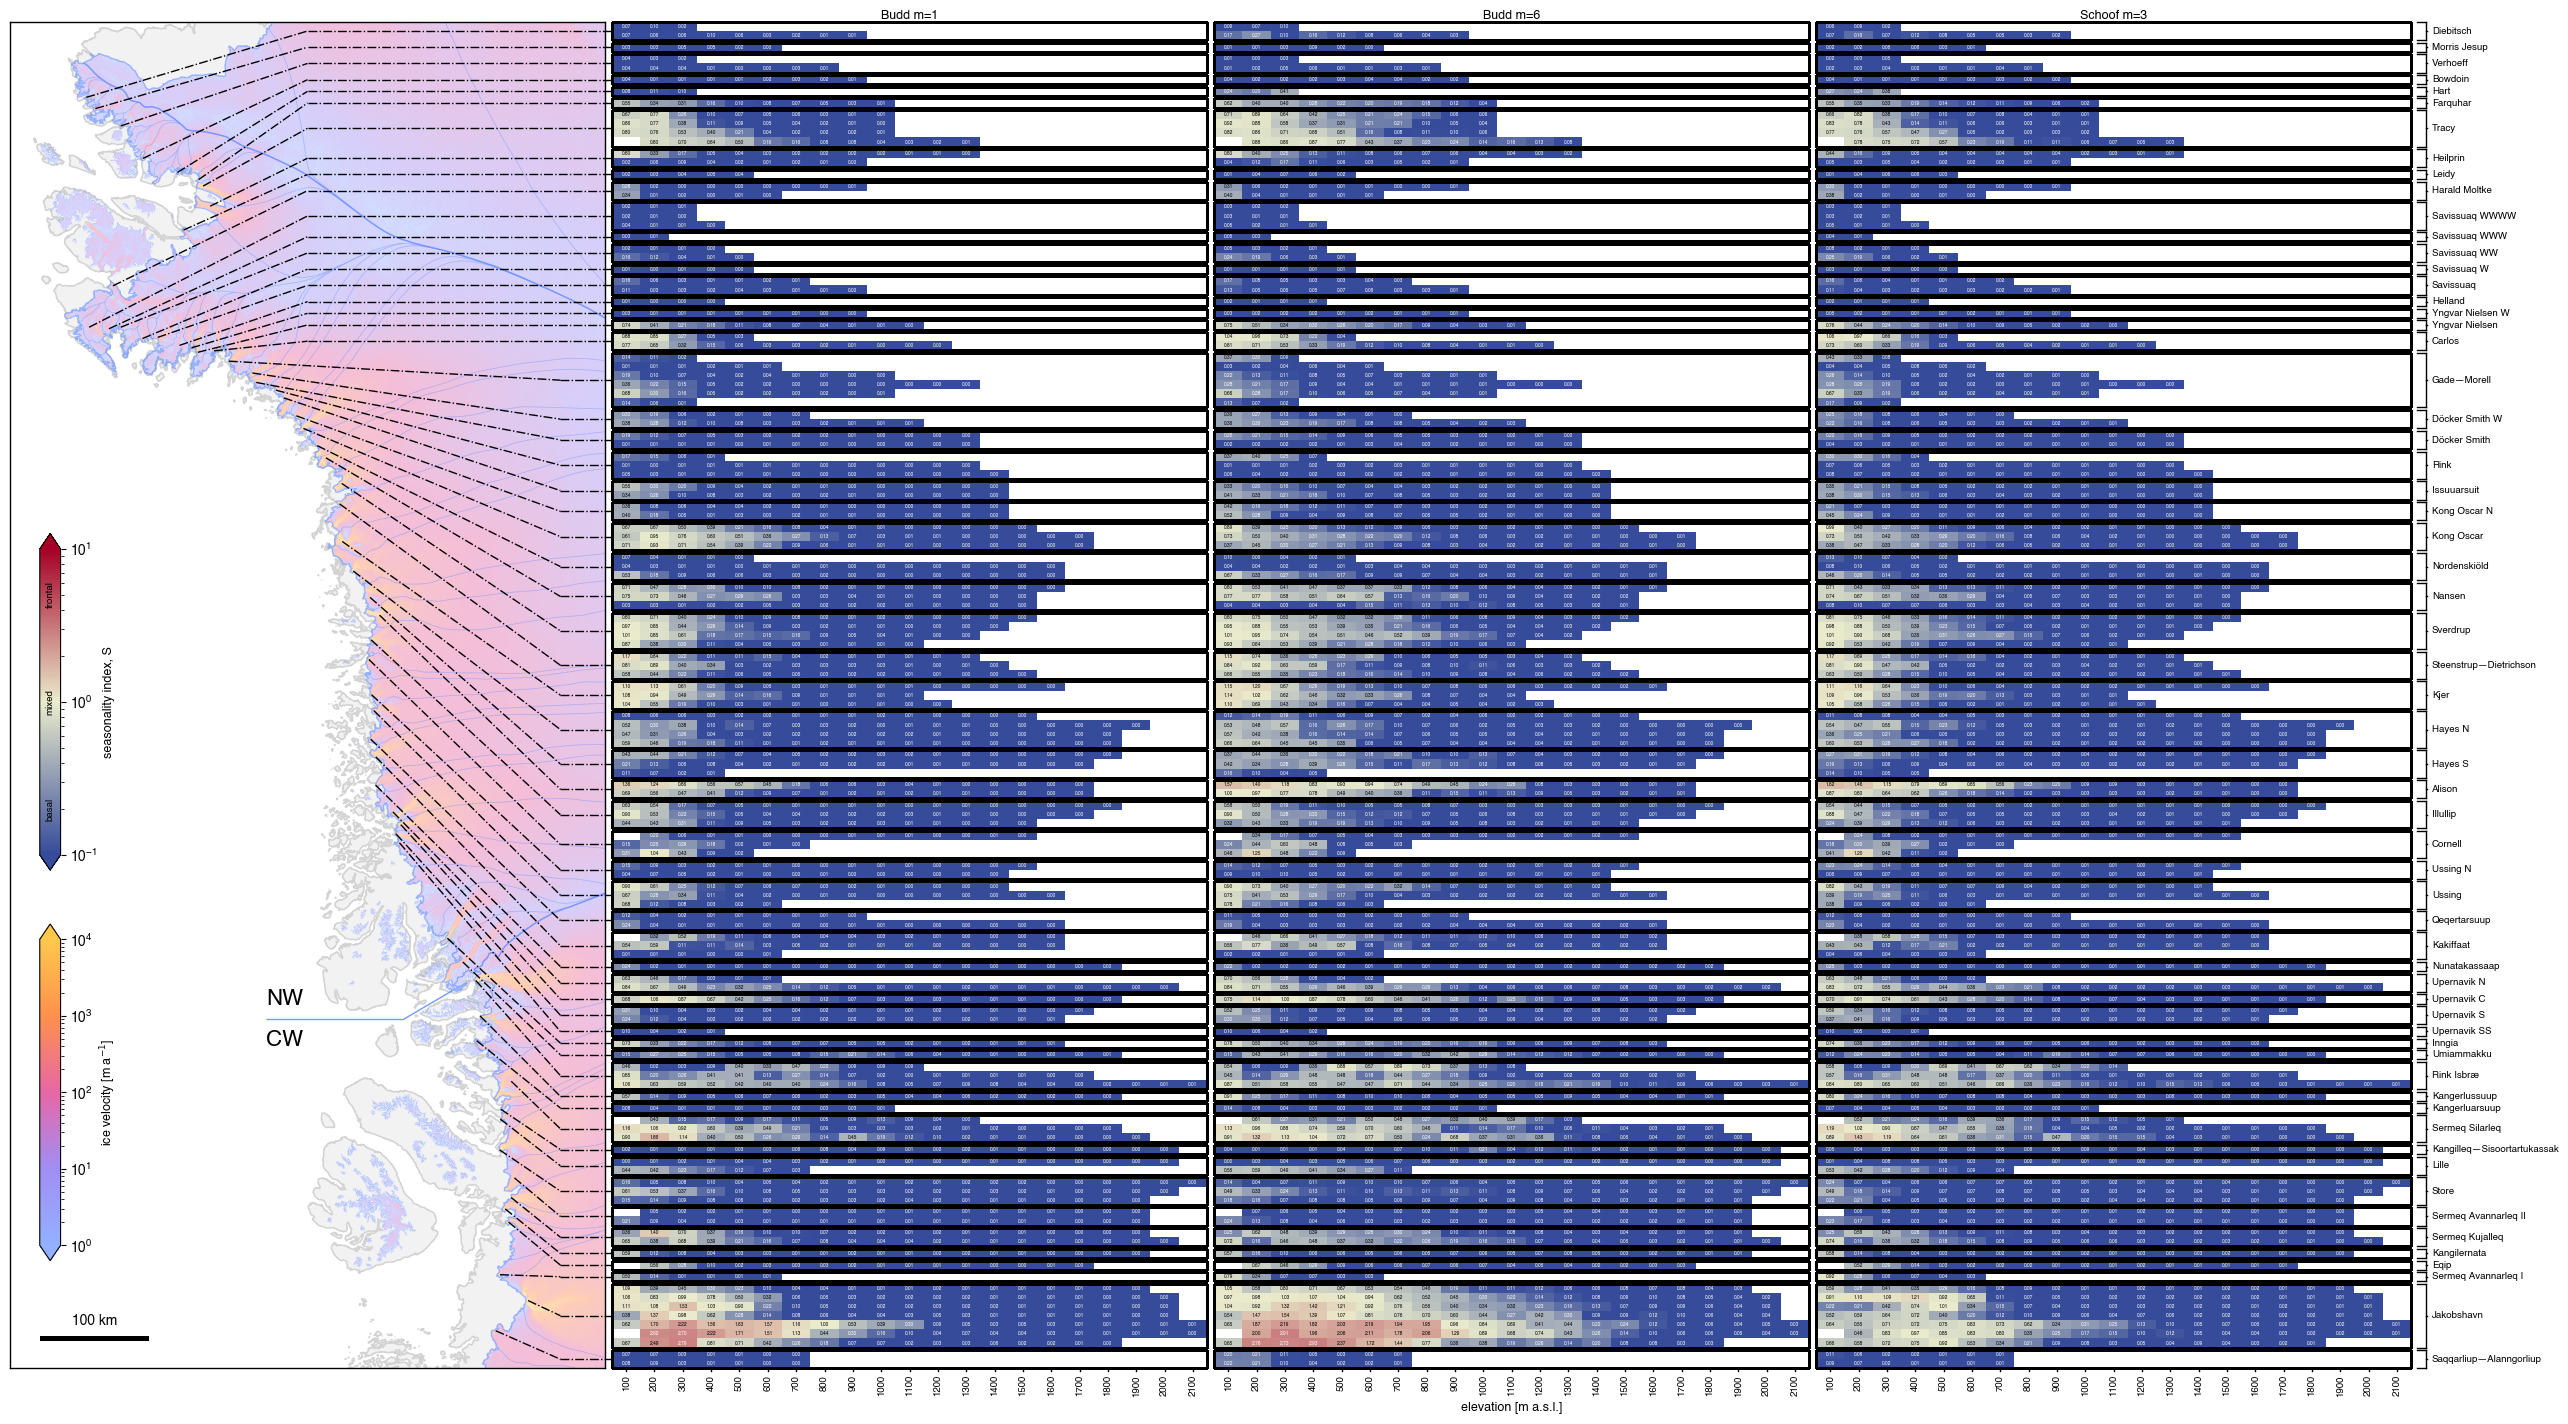

In [8]:
#supplement map with three fric heatmaps

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from matplotlib import patches as mpatches
from math import ceil
from shapely.geometry import mapping
import rasterio.mask as rmask
from shapely.geometry import Point

# === Global font: Helvetica ===
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['mathtext.fontset'] = 'dejavusans'

# --- Paths ---
os.chdir("/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Jess ITS_LIVE v2/Map")
out_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Manuscript/Graphs/Map-Heatmap"
os.makedirs(out_dir, exist_ok=True)

heat_csv_fric1 = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric1.csv"
heat_csv_fric3 = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric3.csv"
heat_csv_fric2 = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/Version 3/Outputs/fric_comp/Multiyear Mean/mean_ratio_fric2.csv"
picks_dir = "/Users/jagon/Documents/Projects/Collabs/Jessica Badgeley/New Points v3/Flowlines of Interest/Picks"

# --- Map data ---
_ = pd.read_csv("2016_20_hmm.csv")  # legacy
outline_gdf     = gpd.read_file("NW_CW_outline.shp").to_crs("EPSG:3413")
outline_big_gdf = gpd.read_file("NW_CW_SW_NO_outline.shp").to_crs("EPSG:3413")
mouginot_gdf    = gpd.read_file("NW_CW_Mouginot_Sectors.shp").to_crs("EPSG:3413")
greenland_gdf   = gpd.read_file("greenland_outlines.shp").to_crs("EPSG:3413")

minx, miny, maxx, maxy = outline_gdf.total_bounds
buffer = 50000
xmin = minx - (buffer*1)
xmax = maxx - (buffer*8)
ymin = miny + buffer
ymax = maxy + buffer
greenland_clipped = greenland_gdf.cx[xmin:xmax, ymin:ymax]

# --- Colour maps & norms ---
heat_cmap   = mcolors.LinearSegmentedColormap.from_list("heat_cmap", ["#364B9A", "#EAECCC", "#A50026"])
driver_norm = LogNorm(vmin=0.1, vmax=10)

custom_cmap = LinearSegmentedColormap.from_list("custom_log_cmap",
                                                ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"])
def lighten_color(c, amount=0.3):
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(c)
    return (1 - (1-r)*(1-amount), 1 - (1-g)*(1-amount), 1 - (1-b)*(1-amount))
light_cmap   = LinearSegmentedColormap.from_list(
    "light_log_cmap",
    [lighten_color(c) for c in ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]]
)
velocity_norm = LogNorm(vmin=1, vmax=10000)

# --- Helper shared by all heatmaps ---
def _prep_heat_df(csv_path):
    df = pd.read_csv(csv_path)
    for col in ["glacier_ID", "flowline_ID", "feature_ID"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    elev_cols = [c for c in df.columns if re.fullmatch(r"\d+", str(c))]
    elev_cols = sorted(elev_cols, key=lambda x: int(x))
    df[elev_cols] = df[elev_cols].apply(pd.to_numeric, errors='coerce')
    df_sorted = df.sort_values(["glacier_ID", "flowline_ID"], ascending=[True, True]).reset_index(drop=True)
    return df_sorted, elev_cols

# --- Match heatmap box to map box ---
map_width  = xmax - xmin
map_height = ymax - ymin

num_cells = 21
cell_size = map_width / num_cells

# --- Line widths (consistency) ---
MAP_LINE_W       = 1.0
GROUP_LINE_W     = MAP_LINE_W
BRACKET_LINE_W   = GROUP_LINE_W
CONNECT_W        = MAP_LINE_W   # connectors

# --- Figure / layout (4 equal panels: Map | fric1 | fric3 | fric2) ---
fig_w = 28.0  # keep per-panel width same as your 2-panel (14in total) setup
width_ratios = [1.0, 1.0, 1.0, 1.0]
map_frac = width_ratios[0] / sum(width_ratios)
fig_h = max(8.0, fig_w * map_frac * (map_height / map_width))

fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(nrows=1, ncols=4, width_ratios=width_ratios, wspace=0.0)
fig.subplots_adjust(left=0.07, right=0.93, top=0.98, bottom=0.13, wspace=0.0)

ax_map  = fig.add_subplot(gs[0, 0])
ax_h1   = fig.add_subplot(gs[0, 1])  # fric1 (closest to map)
ax_hmid = fig.add_subplot(gs[0, 2])  # fric3 (middle)
ax_h3   = fig.add_subplot(gs[0, 3])  # fric2 (rightmost)

# Ensure the heatmap axes patches hide anything behind them
for ax in (ax_h1, ax_hmid, ax_h3):
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    ax.patch.set_zorder(20)

# =========================
# MAP (left) — grey shading outside outline_big_gdf + raster clipped to Mouginot basins
# =========================
try:
    gap_geom = greenland_clipped.unary_union.difference(mouginot_gdf.unary_union)
    gap_gdf  = gpd.GeoDataFrame(geometry=[gap_geom], crs=greenland_clipped.crs)
except Exception:
    gap_gdf = gpd.overlay(greenland_clipped, outline_big_gdf, how='difference')
gap_gdf.plot(ax=ax_map, facecolor='#F2F2F2', edgecolor='none', linewidth=0)
greenland_clipped.plot(ax=ax_map, edgecolor='lightgrey', facecolor='none', linewidth=MAP_LINE_W)

with rasterio.open("v_2022.tif") as src:
    clip_gdf = mouginot_gdf
    if clip_gdf.crs is not None and src.crs is not None:
        if clip_gdf.crs.to_string().upper() != src.crs.to_string().upper():
            clip_gdf = clip_gdf.to_crs(src.crs)
    geoms = [mapping(geom) for geom in clip_gdf.geometry if not geom.is_empty]
    masked, _ = rmask.mask(src, geoms, crop=False, filled=True)
    data = masked[0].astype(float)
    data[data <= 0] = np.nan
    ax_map.imshow(
        data, cmap=custom_cmap, norm=velocity_norm,
        extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
        origin='upper', interpolation='none', alpha=0.3
    )

# Outlines over the raster
mouginot_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.25, facecolor='none', linewidth=MAP_LINE_W*0.5)
outline_big_gdf.plot(ax=ax_map, edgecolor="#648FFF", alpha=0.5,  facecolor='none', linewidth=MAP_LINE_W)

# Map bounds, style, spines
ax_map.set_xlim(xmin, xmax)
ax_map.set_ylim(ymin, ymax)
ax_map.set_aspect('equal')
ax_map.set_title("")
ax_map.set_xticks([]); ax_map.set_yticks([])
ax_map.set_xlabel(""); ax_map.set_ylabel("")
for side in ax_map.spines:
    ax_map.spines[side].set_visible(True)
    ax_map.spines[side].set_linewidth(MAP_LINE_W)
    ax_map.spines[side].set_edgecolor('black')
    ax_map.spines[side].set_zorder(10)

# Scale bar + “NO”
scalebar_length = 100_000
scalebar_height = 5000
x_bar = xmin + 0.05 * (xmax - xmin)
y_bar = ymin + 0.02 * (ymax - ymin)
ax_map.add_patch(plt.Rectangle((x_bar, y_bar), scalebar_length, scalebar_height, facecolor='black', zorder=12))
ax_map.text(x_bar + scalebar_length / 2, y_bar + scalebar_height + 7000, "100 km", ha='center', va='bottom', fontsize=10, zorder=12)

# NW/CW divider & labels (unchanged)
OL_COLOR = "#648FFF"; OL_LW = MAP_LINE_W; OL_ALPHA = 0.9
xA, yA = -252750.652, -1989477.458
xB, yB = -296916.769, -2015351.266
xC, yC = -423553.783, -2015351.266
ax_map.plot([xA, xB], [yA, yB], color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA, solid_capstyle='butt', zorder=12)
ax_map.plot([xB, xC], [yB, yC], color=OL_COLOR, linewidth=OL_LW, alpha=OL_ALPHA, solid_capstyle='butt', zorder=12)
dy = 10000
ax_map.text(xC + dy*1.7, yC + dy*0.8, "NW", ha='center', va='bottom', fontsize=16, color='black', zorder=13)
ax_map.text(xC + dy*1.7, yC - dy,     "CW", ha='center', va='top',    fontsize=16, color='black', zorder=13)

# Legends (unchanged)
def _add_inmap_axes(ax, rel_left, rel_bottom, rel_width, rel_height):
    bb = ax.get_position()
    return fig.add_axes([bb.x0 + rel_left * bb.width,
                         bb.y0 + rel_bottom * bb.height,
                         rel_width * bb.width,
                         rel_height * bb.height])

cax_vel = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.08, rel_width=0.035, rel_height=0.25)
cax_drv = _add_inmap_axes(ax_map, rel_left=0.05, rel_bottom=0.37, rel_width=0.035, rel_height=0.25)
sm_driver = plt.cm.ScalarMappable(norm=driver_norm, cmap=heat_cmap); sm_driver.set_array([])
cbar_drv = plt.colorbar(sm_driver, cax=cax_drv, orientation='vertical', extend='both')
cbar_drv.set_label("seasonality index, S", fontsize=9)
cbar_drv.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_drv.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_drv.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_drv.ax.yaxis.set_minor_formatter(NullFormatter())
cax_drv.text(0.5, 0.85, "frontal", ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.50, "mixed",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)
cax_drv.text(0.5, 0.15, "basal",   ha='center', va='center', transform=cax_drv.transAxes, rotation=90, fontsize=7)

sm_raster = plt.cm.ScalarMappable(norm=velocity_norm, cmap=light_cmap); sm_raster.set_array([])
cbar_vel = plt.colorbar(sm_raster, cax=cax_vel, orientation='vertical', extend='both')
cbar_vel.set_label("ice velocity [m a$^{-1}$]", fontsize=9)
cbar_vel.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar_vel.ax.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(2, 10))))
cbar_vel.ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
cbar_vel.ax.yaxis.set_minor_formatter(NullFormatter())

# =========================
# HEATMAP 1 (fric1) — closest to map (connectors ON), no right-side glacier names
# =========================
hm_df1, elev_cols1 = _prep_heat_df(heat_csv_fric1)

groups1      = hm_df1["glacier_ID"].to_numpy()
unique_gids1 = pd.unique(groups1)
n_rows1      = len(hm_df1)

nominal_row_h1  = map_height / max(1, n_rows1)
gap_thin1       = 0.25 * nominal_row_h1
total_gap_h1    = gap_thin1 * max(0, len(pd.unique(groups1)) - 1)
if total_gap_h1 > 0.15 * map_height:
    gap_thin1    = (0.15 * map_height) / max(1, len(pd.unique(groups1)) - 1)
    total_gap_h1 = gap_thin1 * max(0, len(pd.unique(groups1)) - 1)

bar_height1 = (map_height - total_gap_h1) / max(1, n_rows1)

y0_list1 = []
acc_gap = 0.0; prev_gid = None
for idx, gid in enumerate(groups1):
    if idx > 0 and gid != prev_gid: acc_gap += gap_thin1
    y0_list1.append(idx * bar_height1 + acc_gap)
    prev_gid = gid
y0_list1 = np.array(y0_list1)

hm_x0, hm_y0 = 0.0, 0.0
hm_x1, hm_y1 = map_width, map_height

ax_h1.margins(0); ax_h1.set_aspect('equal')
for side in ax_h1.spines: ax_h1.spines[side].set_visible(False)

NAME_FONT = 7
VAL_FONT  = max(3.5, NAME_FONT * 0.5)

for idx, row in hm_df1.iterrows():
    y0 = y0_list1[idx]
    vals = pd.to_numeric(row[elev_cols1], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0: padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]; x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_h1.add_patch(plt.Rectangle((x, y0), cell_size, bar_height1,
                             facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_h1.add_patch(plt.Rectangle((x, y0), cell_size, bar_height1,
                         facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        ax_h1.text(x + 0.5*cell_size, y0 + 0.5*bar_height1, f"{v:.2f}",
                   ha='center', va='center', fontsize=VAL_FONT,
                   color=('black' if (0.2126*face_rgba[0] + 0.7152*face_rgba[1] + 0.0722*face_rgba[2])>0.6 else 'white'),
                   clip_on=False, zorder=27)

# subgroup outlines
group_bounds1 = {}
for gid in unique_gids1:
    gdf_gid = hm_df1[hm_df1["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min(); bot_idx = gdf_gid.index.max()
    y_top = y0_list1[top_idx]; y_bot = y0_list1[bot_idx] + bar_height1
    group_bounds1[int(gid)] = (float(y_top), float(y_bot))
    rect = plt.Rectangle((hm_x0, y_top), (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black', linewidth=GROUP_LINE_W,
                         joinstyle='miter', antialiased=False, clip_on=False, zorder=30)
    ax_h1.add_patch(rect)

# x-axis ticks & labels (numbers only; no "elevation ..." label on this panel)
trans_xdata_yaxes1 = transforms.blended_transform_factory(ax_h1.transData, ax_h1.transAxes)
tick_y0_ax, tick_y1_ax = -0.002, -0.000
for i, col in enumerate(elev_cols1[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_h1.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                          transform=trans_xdata_yaxes1, color='black',
                          linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols1[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_h1.text(cx, -0.005, str(col), transform=trans_xdata_yaxes1,
               ha='center', va='top', fontsize=7, rotation=90, clip_on=False, zorder=30)

# Title (black)
ax_h1.text(0.5, 1.0, "Budd m=1",
           transform=ax_h1.transAxes, ha='center', va='bottom',
           fontsize=9, color='black', clip_on=False, zorder=30)

ax_h1.set_xlim(hm_x0, hm_x0 + map_width)
ax_h1.set_ylim(hm_y0, hm_y0 + map_height)
ax_h1.invert_yaxis()
ax_h1.set_xticks([]); ax_h1.set_yticks([])
ax_h1.set_xlabel(""); ax_h1.set_ylabel("")

# For connectors later, precompute flowlines per feature_ID on fric1
fl_dict1 = {}
if "feature_ID" in hm_df1.columns:
    for fid, sub in hm_df1.groupby("feature_ID"):
        try:
            arr = np.sort(sub["flowline_ID"].dropna().astype(int).unique())
            if len(arr) > 0:
                fl_dict1[int(fid)] = arr
        except Exception:
            continue

# =========================
# HEATMAP 2 (fric3) — middle panel (no connectors, no right labels), shows the x-axis label
# =========================
hm_df2, elev_cols2 = _prep_heat_df(heat_csv_fric3)
groups2      = hm_df2["glacier_ID"].to_numpy()
unique_gids2 = pd.unique(groups2)
n_rows2      = len(hm_df2)
nominal_row_h2  = map_height / max(1, n_rows2)
gap_thin2       = 0.25 * nominal_row_h2
total_gap_h2    = gap_thin2 * max(0, len(pd.unique(groups2)) - 1)
if total_gap_h2 > 0.15 * map_height:
    gap_thin2    = (0.15 * map_height) / max(1, len(pd.unique(groups2)) - 1)
    total_gap_h2 = gap_thin2 * max(0, len(pd.unique(groups2)) - 1)
bar_height2 = (map_height - total_gap_h2) / max(1, n_rows2)
y0_list2 = []
acc_gap = 0.0; prev_gid = None
for idx, gid in enumerate(groups2):
    if idx > 0 and gid != prev_gid: acc_gap += gap_thin2
    y0_list2.append(idx * bar_height2 + acc_gap)
    prev_gid = gid
y0_list2 = np.array(y0_list2)

ax_hmid.margins(0); ax_hmid.set_aspect('equal')
for side in ax_hmid.spines: ax_hmid.spines[side].set_visible(False)

for idx, row in hm_df2.iterrows():
    y0 = y0_list2[idx]
    vals = pd.to_numeric(row[elev_cols2], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0: padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]; x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_hmid.add_patch(plt.Rectangle((x, y0), cell_size, bar_height2,
                               facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_hmid.add_patch(plt.Rectangle((x, y0), cell_size, bar_height2,
                           facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        ax_hmid.text(x + 0.5*cell_size, y0 + 0.5*bar_height2, f"{v:.2f}",
                     ha='center', va='center', fontsize=VAL_FONT,
                     color=('black' if (0.2126*face_rgba[0] + 0.7152*face_rgba[1] + 0.0722*face_rgba[2])>0.6 else 'white'),
                     clip_on=False, zorder=27)

# subgroup outlines
group_bounds2 = {}
for gid in unique_gids2:
    gdf_gid = hm_df2[hm_df2["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min(); bot_idx = gdf_gid.index.max()
    y_top = y0_list2[top_idx]; y_bot = y0_list2[bot_idx] + bar_height2
    group_bounds2[int(gid)] = (float(y_top), float(y_bot))
    rect = plt.Rectangle((hm_x0, y_top), (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black', linewidth=GROUP_LINE_W,
                         joinstyle='miter', antialiased=False, clip_on=False, zorder=30)
    ax_hmid.add_patch(rect)

# x-axis ticks & labels + ONLY this panel has the axis label text
trans_xdata_yaxes2 = transforms.blended_transform_factory(ax_hmid.transData, ax_hmid.transAxes)
for i, col in enumerate(elev_cols2[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_hmid.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                            transform=trans_xdata_yaxes2, color='black',
                            linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols2[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_hmid.text(cx, -0.005, str(col), transform=trans_xdata_yaxes2,
                 ha='center', va='top', fontsize=7, rotation=90, clip_on=False, zorder=30)
ax_hmid.text(0.5, -0.025, "elevation [m a.s.l.]",
             transform=ax_hmid.transAxes, ha='center', va='top',
             fontsize=9, clip_on=False, zorder=30)

# Title (black)
ax_hmid.text(0.5, 1.0, "Budd m=6",
             transform=ax_hmid.transAxes, ha='center', va='bottom',
             fontsize=9, color='black', clip_on=False, zorder=30)

ax_hmid.set_xlim(hm_x0, hm_x0 + map_width)
ax_hmid.set_ylim(hm_y0, hm_y0 + map_height)
ax_hmid.invert_yaxis()
ax_hmid.set_xticks([]); ax_hmid.set_yticks([])
ax_hmid.set_xlabel(""); ax_hmid.set_ylabel("")

# =========================
# HEATMAP 3 (fric2) — rightmost (no connectors), glacier names ON (right side only)
# =========================
hm_df3, elev_cols3 = _prep_heat_df(heat_csv_fric2)
groups3      = hm_df3["glacier_ID"].to_numpy()
unique_gids3 = pd.unique(groups3)
n_rows3      = len(hm_df3)
nominal_row_h3  = map_height / max(1, n_rows3)
gap_thin3       = 0.25 * nominal_row_h3
total_gap_h3    = gap_thin3 * max(0, len(pd.unique(groups3)) - 1)
if total_gap_h3 > 0.15 * map_height:
    gap_thin3    = (0.15 * map_height) / max(1, len(pd.unique(groups3)) - 1)
    total_gap_h3 = gap_thin3 * max(0, len(pd.unique(groups3)) - 1)
bar_height3 = (map_height - total_gap_h3) / max(1, n_rows3)
y0_list3 = []
acc_gap = 0.0; prev_gid = None
for idx, gid in enumerate(groups3):
    if idx > 0 and gid != prev_gid: acc_gap += gap_thin3
    y0_list3.append(idx * bar_height3 + acc_gap)
    prev_gid = gid
y0_list3 = np.array(y0_list3)

ax_h3.margins(0); ax_h3.set_aspect('equal')
for side in ax_h3.spines: ax_h3.spines[side].set_visible(False)

for idx, row in hm_df3.iterrows():
    y0 = y0_list3[idx]
    vals = pd.to_numeric(row[elev_cols3], errors='coerce').to_numpy(float).ravel()
    padded = np.full(num_cells, np.nan, dtype=float)
    take = min(num_cells, len(vals))
    if take > 0: padded[:take] = vals[:take]
    for i in range(num_cells):
        v = padded[i]; x = hm_x0 + i*cell_size
        if not np.isfinite(v):
            ax_h3.add_patch(plt.Rectangle((x, y0), cell_size, bar_height3,
                              facecolor='white', edgecolor='none', linewidth=0.0, zorder=25))
            continue
        face_rgba = heat_cmap(driver_norm(v))
        ax_h3.add_patch(plt.Rectangle((x, y0), cell_size, bar_height3,
                          facecolor=face_rgba, edgecolor='none', linewidth=0.0, zorder=25))
        ax_h3.text(x + 0.5*cell_size, y0 + 0.5*bar_height3, f"{v:.2f}",
                   ha='center', va='center', fontsize=VAL_FONT,
                   color=('black' if (0.2126*face_rgba[0] + 0.7152*face_rgba[1] + 0.0722*face_rgba[2])>0.6 else 'white'),
                   clip_on=False, zorder=27)

# subgroup outlines
group_bounds3 = {}
for gid in unique_gids3:
    gdf_gid = hm_df3[hm_df3["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min(); bot_idx = gdf_gid.index.max()
    y_top = y0_list3[top_idx]; y_bot = y0_list3[bot_idx] + bar_height3
    group_bounds3[int(gid)] = (float(y_top), float(y_bot))
    rect = plt.Rectangle((hm_x0, y_top), (hm_x1 - hm_x0), (y_bot - y_top),
                         facecolor='none', edgecolor='black', linewidth=GROUP_LINE_W,
                         joinstyle='miter', antialiased=False, clip_on=False, zorder=30)
    ax_h3.add_patch(rect)

# Right-side brackets + glacier names (RIGHTMOST ONLY)
trans_xaxes_ydata3 = transforms.blended_transform_factory(ax_h3.transAxes, ax_h3.transData)
vline_x     = 1.025
stub_len_ax = 0.015
NAME_FONT = 7
for gid in unique_gids3:
    gdf_gid = hm_df3[hm_df3["glacier_ID"] == gid]
    top_idx = gdf_gid.index.min(); bot_idx = gdf_gid.index.max()
    y_top = y0_list3[top_idx]; y_bot = y0_list3[bot_idx] + bar_height3
    y_mid = 0.5 * (y_top + y_bot)
    ax_h3.add_line(Line2D([vline_x, vline_x], [y_top, y_bot],
                          transform=trans_xaxes_ydata3, color='black',
                          linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_h3.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_top, y_top],
                          transform=trans_xaxes_ydata3, color='black',
                          linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_h3.add_line(Line2D([vline_x - stub_len_ax, vline_x], [y_bot, y_bot],
                          transform=trans_xaxes_ydata3, color='black',
                          linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    mid_tick_len = 0.002
    ax_h3.add_line(Line2D([vline_x, vline_x + mid_tick_len], [y_mid, y_mid],
                          transform=trans_xaxes_ydata3, color='black',
                          linewidth=BRACKET_LINE_W, clip_on=False, zorder=30))
    ax_h3.text(vline_x + 0.01, y_mid, str(hm_df3.loc[top_idx, "glacier_name"]),
               transform=trans_xaxes_ydata3, ha='left', va='center',
               fontsize=NAME_FONT, clip_on=False, zorder=30)

# x-axis ticks & labels (numbers only)
trans_xdata_yaxes3 = transforms.blended_transform_factory(ax_h3.transData, ax_h3.transAxes)
for i, col in enumerate(elev_cols3[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_h3.add_line(Line2D([cx, cx], [tick_y0_ax, tick_y1_ax],
                          transform=trans_xdata_yaxes3, color='black',
                          linewidth=MAP_LINE_W, clip_on=False, zorder=30))
for i, col in enumerate(elev_cols3[:num_cells]):
    cx = hm_x0 + i*cell_size + 0.5*cell_size
    ax_h3.text(cx, -0.005, str(col), transform=trans_xdata_yaxes3,
               ha='center', va='top', fontsize=7, rotation=90, clip_on=False, zorder=30)

# Title (black)
ax_h3.text(0.5, 1.0, "Schoof m=3",
           transform=ax_h3.transAxes, ha='center', va='bottom',
           fontsize=9, color='black', clip_on=False, zorder=30)

ax_h3.set_xlim(hm_x0, hm_x0 + map_width)
ax_h3.set_ylim(hm_y0, hm_y0 + map_height)
ax_h3.invert_yaxis()
ax_h3.set_xticks([]); ax_h3.set_yticks([])
ax_h3.set_xlabel(""); ax_h3.set_ylabel("")

# =========================
# MAP↔HEATMAP dotted connectors (ONLY for fric1, the panel next to the map)
# =========================
plt.draw()
mb  = ax_map.get_position()
hb1 = ax_h1.get_position()

SPECIAL_NTH = {
    57: 30, 53: 45, 49: 50, 30: 30,
    13: 100, 10: 20, 7: 10, 18: 100,
}

for gid in pd.unique(hm_df1["glacier_ID"].to_numpy()):
    gid_int = int(gid)
    if gid_int not in group_bounds1:
        continue

    sub_gid = hm_df1[hm_df1["glacier_ID"] == gid_int]
    if "feature_ID" in sub_gid.columns and sub_gid["feature_ID"].notna().any():
        feat_counts = sub_gid["feature_ID"].dropna().astype(int).value_counts()
        chosen_fid  = int(feat_counts.index[0])
    else:
        continue

    if chosen_fid in fl_dict1 and len(fl_dict1[chosen_fid]) > 0:
        fls = fl_dict1[chosen_fid]
        idx_mid = ceil(len(fls)/2) - 1
        chosen_fl = int(fls[idx_mid])
    else:
        fls_sub = np.sort(sub_gid["flowline_ID"].dropna().astype(int).unique())
        if len(fls_sub) == 0: continue
        idx_mid = ceil(len(fls_sub)/2) - 1
        chosen_fl = int(fls_sub[idx_mid])

    gj_path = os.path.join(picks_dir, f"gl_{chosen_fid}_{chosen_fl}.geojson")
    nth = SPECIAL_NTH.get(gid_int, 1)

    # === Helper: get the N-th coordinate from a GeoJSON in EPSG:3413 ===
    def _nth_xy_3413(geojson_path, n=1):
        try:
            gdf = gpd.read_file(geojson_path)
        except Exception:
            return None
        try:
            if gdf.crs is None:
                gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:3413")
            elif str(gdf.crs).upper() != "EPSG:3413":
                gdf = gdf.to_crs("EPSG:3413")
        except Exception:
            pass
        if len(gdf) == 0 or gdf.geometry.is_empty.all():
            return None

        def _collect_coords(geom):
            coords = []
            try:
                gt = geom.geom_type
            except Exception:
                gt = None
            if hasattr(geom, "coords"):
                coords.extend(list(geom.coords))
            if gt == "Polygon":
                try:
                    coords.extend(list(geom.exterior.coords))
                except Exception:
                    pass
            if hasattr(geom, "geoms"):
                try:
                    for g in geom.geoms:
                        coords.extend(_collect_coords(g))
                except Exception:
                    pass
            return coords

        geom = gdf.geometry.iloc[0]
        coords = _collect_coords(geom)
        if len(coords) == 0:
            c = geom.representative_point()
            return (c.x, c.y)
        idx = max(0, min(len(coords) - 1, n - 1))
        x0, y0 = coords[idx]
        return (float(x0), float(y0))

    pt = _nth_xy_3413(gj_path, n=nth)
    if pt is None:
        continue
    px, py = pt

    y_top, y_bot = group_bounds1[gid_int]
    y_mid_heat = 0.5*(y_top + y_bot)
    y_mid_map  = ymax - y_mid_heat

    map_w = (xmax - xmin)
    if 1 <= gid_int <= 21:
        bend_frac = 0.50
    elif 22 <= gid_int <= 60:
        bend_frac = 0.925
    elif 61 <= gid_int <= 63:
        bend_frac = 0.925
    else:
        bend_frac = 1.00
    x_bend = xmin + bend_frac * map_w

    # Dotted connectors on the MAP
    ax_map.plot([px, x_bend], [py, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)
    ax_map.plot([x_bend, xmax], [y_mid_map, y_mid_map],
                color='black', linewidth=CONNECT_W, linestyle='-.',
                solid_capstyle='butt', dash_capstyle='butt', zorder=50)

    # Dotted bridge across the map→first-heatmap gap, drawn behind the heatmaps
    y_norm = (y_mid_map - ymin) / (ymax - ymin)
    y_fig  = mb.y0 + y_norm * mb.height
    x_left = mb.x1
    x_right = hb1.x0

    bridge = Line2D([x_left, x_right], [y_fig, y_fig],
                    transform=fig.transFigure,
                    color='black', linewidth=CONNECT_W, linestyle='-.',
                    solid_capstyle='butt', dash_capstyle='butt',
                    zorder=-1)
    fig.add_artist(bridge)

# --- Save ---
pdf_path = os.path.join(out_dir, "map_supp.pdf")
jpg_path = os.path.join(out_dir, "map_supp.jpg")
fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
fig.savefig(jpg_path, dpi=600, bbox_inches='tight')
print("Saved:", pdf_path, "and", jpg_path)
plt.show()